In [58]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
import osmnx as ox
import networkx as nx
import ast
from shapely import wkt

TIME_INTERVAL = '1H'

# Load INRIX speed data and conversion data
inrix_df = pd.read_csv('../data/Hamilton-County-INRIX.csv')
conversion_df = pd.read_csv('../data/XD_Identification.csv')

ms_buildings = pd.read_csv('../move_OD/Hamilton_Tennessee_2024-03-23_2024-03-23/county_buildings_MS.csv')
ms_buildings['location'] = ms_buildings['location'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
ms_buildings_locations = list(ms_buildings['location'].apply(tuple).unique())

## Load ODs

In [59]:
desired_date = pd.Timestamp("2025-03-10 01:00:00").date()
inrix_df["measurement_tstamp"] = pd.to_datetime(inrix_df["measurement_tstamp"])
inrix_df = inrix_df[inrix_df["measurement_tstamp"].dt.date == desired_date]

In [60]:
od_df = pd.read_csv('../move_OD/Hamilton_Tennessee_2024-03-23_2024-03-23/lodes_combs/lodes_2024-03-23.csv')

od_pairs = []
for _, row in od_df.iterrows():
    orig_dep = pd.Timestamp(row['departure_time'])
    # snap to 2‑hour bins
    dep_time = orig_dep.floor(TIME_INTERVAL)
    time_str = dep_time.strftime('%H:%M:%S')

    od_pairs.append({
        "origin_geoid":             row['h_geocode'],
        "destination_geoid":        row['w_geocode'],
        "origin":             (row['origin_loc_lat'], row['origin_loc_lon']),
        "destination":        (row['dest_loc_lat'], row['dest_loc_lon']),
        "departure_time":     pd.Timestamp(f"{desired_date} {time_str}"),
        "possible_dest_loc":  row['possible_dest_loc']
    })

In [61]:
census_depart_times = pd.read_csv('/home/rishav/move_od/move_OD/Hamilton_Tennessee_2024-03-23_2024-03-23/census_data/census_depart_times.csv')

In [71]:
calibrated_df = pd.read_csv('/home/rishav/move_od/routing/calibrated_df.csv')
calibrated_df['departure_time'] = pd.to_datetime(calibrated_df['departure_time'])
calibrated_df['time_in_seconds'] = calibrated_df['departure_time'].dt.hour * 3600 + calibrated_df['departure_time'].dt.minute * 60 + calibrated_df['departure_time'].dt.second

In [72]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# Define time bins and labels to match census_depart_times
time_bins = [0, 5 * 3600, 5.5 * 3600, 6 * 3600, 6.5 * 3600, 7 * 3600, 7.5 * 3600, 8 * 3600, 8.5 * 3600, 9 * 3600, 10 * 3600, 11 * 3600, 12 * 3600, 16 * 3600, 24 * 3600]
time_labels = [
    '12am_to_4:59am_estimate', '5am_to_5:29am_estimate', '5:30am_to_5:59am_estimate',
    '6am_to_6:29am_estimate', '6:30am_to_6:59am_estimate', '7am_to_7:29am_estimate',
    '7:30am_to_7:59am_estimate', '8am_to_8:29am_estimate', '8:30am_to_8:59am_estimate',
    '9am_to_9:59am_estimate', '10am_to_10:59am_estimate', '11am_to_11:59am_estimate',
    '12pm_to_3:59pm_estimate', '4pm_to_11:59pm_estimate'
]

# Prepare results
comparison_results = []

# Iterate over each h_geocode in od_df
for h_geocode, group in tqdm(calibrated_df.groupby('origin_geoid'), desc="Processing h_geocode"):
    # Calculate the distribution of departure_time_secs in od_df
    od_distribution, _ = np.histogram(group['time_in_seconds'], bins=time_bins)
    od_distribution = od_distribution / od_distribution.sum()  # Normalize

    # Get the corresponding row in census_depart_times
    census_row = census_depart_times[census_depart_times['GEO_ID'] == h_geocode]
    if census_row.empty:
        continue  # Skip if no matching GEO_ID in census data

    # Extract the census distribution
    census_distribution = census_row[time_labels].values.flatten()
    census_distribution = census_distribution / census_distribution.sum()  # Normalize

    # Calculate RMSE and MAE
    rmse = np.sqrt(np.mean((od_distribution - census_distribution) ** 2))
    mae = np.mean(np.abs(od_distribution - census_distribution))

    # Store the results
    comparison_results.append({
        'h_geocode': h_geocode,
        'rmse': rmse,
        'mae': mae,
        'od_distribution': od_distribution,
        'census_distribution': census_distribution
    })

# Convert results to a DataFrame for analysis
comparison_df = pd.DataFrame(comparison_results)

# Display the top 10 h_geocodes with the lowest RMSE
comparison_df.sort_values('rmse')

Processing h_geocode:   0%|          | 0/255 [00:00<?, ?it/s]

,h_geocode,rmse,mae,od_distribution,census_distribution
45,470650030002,0.000000,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
176,470650113231,0.147922,0.095680,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.4967860422405877, ...","[0.0, 0.00463821892393321, 0.08812615955473098..."
98,470650104313,0.169591,0.104686,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0176, 0.0, 0.0256, 0.0, 0.0192, 0.1184, 0.1..."
253,470650124003,0.176535,0.119301,"[0.0, 0.0, 0.0, 0.4586206896551724, 0.0, 0.541...","[0.031914893617021274, 0.01773049645390071, 0...."
226,470650116006,0.178825,0.088940,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.025806451612903226, 0.0838709677419354..."
...,...,...,...,...,...
113,470650105011,0.306601,0.142857,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.041176470588235294, 0.0, 0.5, 0.0, 0.082352..."
117,470650105015,0.308158,0.142857,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.03162055335968379, 0.0, 0.0, 0.047430830039..."
217,470650114482,0.310772,0.142857,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.509493670886076, 0.0, 0.05696202531645..."
26,470650020002,0.314842,0.142857,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4285714285714..."


In [69]:
calibrated_df

,Unnamed: 0,origin_geoid,destination_geoid,origin_node,destination_node,departure_time,departure_time_bin,arrival_time,travel_time_min,travel_distance_mi,time_bin,time_bin_name,trip_id,initial_weight,calibrated_weight,calibrated_weight_norm
0,0,470650114461,470650124002,5206877344,4163482104,2025-03-10 01:00:00,1,2025-03-10 01:20:31.260820593,20.521014,9.987926,4.0,20_to_24_minutes,0,0.000844,0.000844,0.000844
1,1,470650114461,470650124002,202649525,1850072765,2025-03-10 00:00:00,0,2025-03-10 00:20:27.096835292,20.451614,9.836811,4.0,20_to_24_minutes,1,0.000844,0.000844,0.000844
2,2,470650114461,470650124002,2489599660,202648588,2025-03-10 02:00:00,2,2025-03-10 02:19:34.286185955,19.571436,10.315033,3.0,15_to_19_minutes,2,0.000844,0.000844,0.000844
3,3,470650114461,470650113114,202671398,2491313686,2025-03-10 02:00:00,2,2025-03-10 02:10:04.445943189,10.074099,5.311202,2.0,10_to_14_minutes,3,0.000844,0.000844,0.000844
4,4,470650114461,470650124002,6482769464,202648588,2025-03-10 02:00:00,2,2025-03-10 02:19:18.920513228,19.315342,10.096851,3.0,15_to_19_minutes,4,0.000844,0.000844,0.000844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145515,145515,470650121004,470650121003,202712087,202702983,2025-03-10 21:00:00,21,2025-03-10 21:02:14.243614231,2.237394,1.383869,0.0,under_5_minutes,145515,0.027027,0.027027,0.027027
145516,145516,470650014002,470650111003,202649709,202608221,2025-03-10 23:00:00,23,2025-03-10 23:26:00.395229698,26.006587,11.233354,5.0,25_to_29_minutes,145516,0.002976,0.000000,0.000000
145517,145517,470650121004,470650121003,7624377853,202709443,2025-03-10 17:00:00,17,2025-03-10 17:03:04.716064149,3.078601,1.983938,0.0,under_5_minutes,145517,0.027027,0.027027,0.027027
145518,145518,470650121004,470650121003,202704254,202703405,2025-03-10 18:00:00,18,2025-03-10 18:06:54.834706023,6.913912,3.490633,1.0,5_to_9_minutes,145518,0.027027,0.000000,0.000000


In [4]:
hourly_inrix_df = (inrix_df
    .set_index('measurement_tstamp')
    .groupby('xd_id')
    .resample(TIME_INTERVAL)  # now resample every 30 minutes instead of hourly
    .agg({
        'speed': 'mean',
        'historical_average_speed': 'mean',
        'reference_speed': 'mean',
        'travel_time_minutes': 'mean',
        'confidence_score': 'mean',
        'cvalue': 'mean'
    })
    .reset_index()
)

# Format the result
hourly_inrix_df = hourly_inrix_df.round(2)  # Round to 2 decimal places

# Extract all unique hourly timestamps
all_hours = hourly_inrix_df["measurement_tstamp"].drop_duplicates().sort_values()

In [5]:
import collections

hourly_graphs = {}  # Store G_hour per timestamp

for hour in all_hours:
    # Filter INRIX for this hour
    inrix_snapshot = hourly_inrix_df[hourly_inrix_df["measurement_tstamp"] == hour]
    
    # Merge with conversion
    merged_df = pd.merge(inrix_snapshot, conversion_df, left_on="xd_id", right_on="xd")
    
    # Create LineStrings
    geometries = [
        LineString([(x1, y1), (x2, y2)])
        for x1, y1, x2, y2 in zip(merged_df["start_longitude"], merged_df["start_latitude"],
                                 merged_df["end_longitude"], merged_df["end_latitude"])
    ]
    inrix_gdf = gpd.GeoDataFrame(merged_df, geometry=geometries, crs="EPSG:4326")
    
    # Fetch OSM network only once (outside loop for efficiency)
    if 'G_base' not in locals():
        # Use the maximum bounds from od_df by combining origin and destination coordinates
        # minx = min(od_df["origin_loc_lon"].min(), od_df["dest_loc_lon"].min())
        # miny = min(od_df["origin_loc_lat"].min(), od_df["dest_loc_lat"].min())
        # maxx = max(od_df["origin_loc_lon"].max(), od_df["dest_loc_lon"].max())
        # maxy = max(od_df["origin_loc_lat"].max(), od_df["dest_loc_lat"].max())
        # minx, miny, maxx, maxy = minx - 0.5, miny - 0.5, maxx + 0.5, maxy + 0.5

        G_base = ox.graph_from_place("Hamilton County, TN, USA", network_type="drive")
        edges_base = ox.graph_to_gdfs(G_base, nodes=False, edges=True).to_crs(epsg=3857)
        
    # Project INRIX and join to edges
    inrix_proj = inrix_gdf.to_crs(epsg=3857)
    joined = gpd.sjoin_nearest(inrix_proj, edges_base, how="left", distance_col="dist")

    # Clone graph
    G_hour = G_base.copy()

    # Update edge weights in G_hour
    for idx, row in joined.iterrows():
        u, v, key = row["index_right0"], row["index_right1"], row["index_right2"]
        speed = row["speed"]
        length = row["length"]
        if pd.notnull(speed) and speed > 0:
            travel_time = (3.6 * length) / speed
            G_hour[u][v][key]["travel_time"] = travel_time
            G_hour[u][v][key]["weight"] = travel_time

    # Assign default weights to zero/None weights
    default_speed_kmh = 80
    for u, v, k, data in G_hour.edges(keys=True, data=True):
        weight = data.get("weight", None)
        if (weight == 0) or (weight is None):
            length = data.get("length", None)
            if length:
                travel_time = (3.6 * length) / default_speed_kmh
                data["weight"] = travel_time

    # Store graph
    hourly_graphs[hour] = G_hour


In [6]:
from tqdm.notebook import tqdm

# Find any graphs where one or more edges lack a 'weight' attribute
graphs_missing_weight = []

for hr, G in tqdm(hourly_graphs.items(),
                  total=len(hourly_graphs),
                  desc="Checking graphs for missing 'weight'"):
    # Stop at first missing edge
    if any('weight' not in data for _, _, data in G.edges(data=True)):
        graphs_missing_weight.append(hr)

if graphs_missing_weight:
    print("Graphs missing 'weight' attribute:", graphs_missing_weight)
else:
    print("All graphs have a 'weight' attribute on every edge.")

Checking graphs for missing 'weight':   0%|          | 0/24 [00:00<?, ?it/s]

All graphs have a 'weight' attribute on every edge.


In [7]:
G_0 = list(hourly_graphs.values())[0]
origins_lon = list(od_df['origin_loc_lon'].values)
origins_lat = list(od_df['origin_loc_lat'].values)
destinations_lon = list(od_df['dest_loc_lon'].values)
destinations_lat = list(od_df['dest_loc_lat'].values)
od_indices = list(od_df.index)

origins_nodes = ox.distance.nearest_nodes(G_0, X=origins_lon, Y=origins_lat)
destinations_nodes = ox.distance.nearest_nodes(G_0, X=destinations_lon, Y=destinations_lat)

od_df['origin_node'] = origins_nodes
od_df['destination_node'] = destinations_nodes

## All origin, dest locations

In [8]:
# ## uses MS buildings data

# origin_locs = pd.read_csv('../move_OD/Hamilton_Tennessee_2024-03-23_2024-03-23/county_residential_buildings.csv')
# origin_locs['intpt'] = origin_locs['intpt'].apply(
#     lambda x: (wkt.loads(x).y, wkt.loads(x).x) if isinstance(x, str) else (x.y, x.x)
# )
# origin_locs['location'] = origin_locs['location'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
# origins = origin_locs['location'].unique().tolist() + origin_locs['intpt'].unique().tolist() + ms_buildings_locations
# origins = list(set(origins))


# dest_locs = pd.read_csv('../move_OD/Hamilton_Tennessee_2024-03-23_2024-03-23/county_work_locations.csv')
# dest_locs['geometry'] = dest_locs['geometry'].apply(
#     lambda x: (wkt.loads(x).y, wkt.loads(x).x) if isinstance(x, str) else (x.y, x.x)
# )
# dest_locs['intpt'] = dest_locs['intpt'].apply(
#     lambda x: (wkt.loads(x).y, wkt.loads(x).x) if isinstance(x, str) else (x.y, x.x)
# )

# dests = dest_locs['geometry'].unique().tolist() + list(dest_locs['intpt'].unique()) + ms_buildings_locations
# dests = list(set(dests))

In [9]:
import pandas as pd
import multiprocessing as mp
from tqdm.notebook import tqdm
import ast

def process_chunk(args):
    chunk_df, _ = args
    origins, dests = [], []
    for _, row in chunk_df.iterrows():
        origins.extend(ast.literal_eval(row['possible_home_loc']))
        dests.extend(ast.literal_eval(row['possible_dest_loc']))
    return origins, dests, len(chunk_df)

def parallelize_processing(od_df, num_processes=None):
    if num_processes is None:
        num_processes = mp.cpu_count()
    pbar = tqdm(total=len(od_df), desc="Processing rows")
    # split into chunks
    num_chunks = num_processes * 4
    chunk_size = max(1, len(od_df) // num_chunks)
    chunks = [(od_df.iloc[i:i+chunk_size], i)
              for i in range(0, len(od_df), chunk_size)]

    all_origins, all_dests = [], []
    def _callback(res):
        origins, dests, count = res
        all_origins.extend(origins)
        all_dests.extend(dests)
        pbar.update(count)

    with mp.Pool(processes=num_processes) as pool:
        for chunk_args in chunks:
            pool.apply_async(process_chunk, args=(chunk_args,), callback=_callback)
        pool.close()
        pool.join()
    pbar.close()

    # dedupe and return lists of tuples
    possible_origins = list({tuple(o) for o in all_origins})
    possible_dests   = list({tuple(d) for d in all_dests})
    return possible_origins, possible_dests

# Usage:
od_df = od_df.drop_duplicates(subset=['possible_home_loc', 'possible_dest_loc'])
origins, dests = parallelize_processing(od_df)

Processing rows:   0%|          | 0/24753 [00:00<?, ?it/s]

In [10]:
G_0 = list(hourly_graphs.values())[0]
origin_lons = [p[1] for p in origins]
origin_lats = [p[0] for p in origins]
destination_lons = [p[1] for p in dests]
destination_lats = [p[0] for p in dests]

origin_nodes = ox.distance.nearest_nodes(G_0, X=origin_lons, Y=origin_lats)
destination_nodes = ox.distance.nearest_nodes(G_0, X=destination_lons, Y=destination_lats)

origin_loc_to_node = {loc: node for loc, node in zip(origins, origin_nodes)}
dest_loc_to_node = {loc: node for loc, node in zip(dests, destination_nodes)}

origin_nodes = list(set(origin_nodes))
destination_nodes = list(set(destination_nodes))

In [11]:
def map_locations_to_nodes(locations, loc_to_node):
    """
    Map a list of locations to their corresponding nodes.
    """
    locations = ast.literal_eval(locations) if isinstance(locations, str) else locations
    res = []
    for loc in locations:
        loc_tuple = tuple(loc)  # Ensure loc is a tuple (hashable)
        res.append(loc_to_node[loc_tuple])
    return res

od_df['possible_home_nodes'] = od_df['possible_home_loc'].apply(
    lambda x: map_locations_to_nodes(x, origin_loc_to_node)
)
od_df['possible_dest_nodes'] = od_df['possible_dest_loc'].apply(
    lambda locs: map_locations_to_nodes(locs, dest_loc_to_node)
)

In [12]:
subset_nodes = set(origin_nodes) | set(destination_nodes)
subset_pts = set(origins) | set(dests)

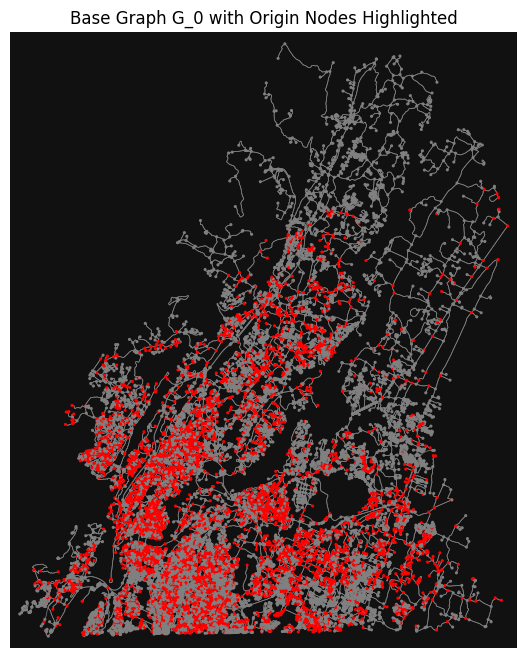

In [13]:
import matplotlib.pyplot as plt
import osmnx as ox

map = G_0
# Create a color map for nodes
node_colors = ['red' if node in subset_nodes else 'gray' for node in map.nodes]

# Plot G_0 with colored nodes
fig, ax = ox.plot_graph(
    map,
    figsize=(8, 8),
    node_size=5,
    node_color=node_colors,
    edge_color='gray',
    edge_linewidth=0.5,
    show=False
)
ax.set_title("Base Graph G_0 with Origin Nodes Highlighted")
plt.show()

## Routing (using hourly graphs)

In [73]:
# Modified process_od_pair function to handle CBG information
def process_od_pair_with_geoid(od_task):
    """Process a single OD pair with CBG information and return the routing result"""
    orig_node, dest_node, dep_time, origin_geoid, dest_geoid = od_task
    
    if isinstance(dep_time, int):
        raise Exception("int dep_time")
    
    # Find closest hour
    hour_to_use = dep_time.floor(TIME_INTERVAL)
    G_hour = hourly_graphs.get(hour_to_use)
    if G_hour is None:
        return None  # Skip if no graph is available for this time

    # Compute shortest path
    try:
        route = nx.shortest_path(G_hour, source=orig_node, target=dest_node, weight="weight")
        # Sum travel time
        total_travel_time_sec = sum(G_hour[u][v][0].get("weight", 0) for u, v in zip(route[:-1], route[1:]))
        
        # Calculate total distance in meters, then convert to miles
        total_distance_m = sum(G_hour[u][v][0].get("length", 0) for u, v in zip(route[:-1], route[1:]))
        total_distance_mi = total_distance_m * 0.000621371  # Convert meters to miles
        
        arrival_time = dep_time + pd.to_timedelta(total_travel_time_sec, unit='s')
        departure_time_bin = hour_to_use.hour

        return {
            "origin_geoid": origin_geoid,           # Add CBG information
            "destination_geoid": dest_geoid,        # Add CBG information
            "origin_node": orig_node,
            "destination_node": dest_node,
            "departure_time": dep_time,
            "departure_time_bin": departure_time_bin,  # Include departure_time_bin
            "arrival_time": arrival_time,
            "travel_time_min": total_travel_time_sec / 60,
            "travel_distance_mi": total_distance_mi,
            "route_nodes": route
        }
    
    except nx.NetworkXNoPath:
        return None  # Skip silently

In [25]:
import pandas as pd
import networkx as nx
import osmnx as ox
import multiprocessing as mp
from tqdm.notebook import tqdm

# Single-process version
print("Processing OD pairs sequentially")

# Collect all OD information
origin_lons = []
origin_lats = []
dest_lons = []
dest_lats = []
departs = []
origin_geoids = []  # Add CBG tracking
dest_geoids = []    # Add CBG tracking

for od in od_pairs:
    dep_time = od["departure_time"]
    origin_lat, origin_lon = od["origin"]
    dest_lat, dest_lon = od["destination"]
    
    # Get CBG information (if available in your od_pairs)
    origin_geoid = od.get("origin_geoid", "unknown")  # Default if not available
    dest_geoid = od.get("destination_geoid", "unknown")  # Default if not available
    
    departs.append(dep_time)
    origin_lons.append(origin_lon)
    origin_lats.append(origin_lat)
    dest_lons.append(dest_lon)
    dest_lats.append(dest_lat)
    origin_geoids.append(origin_geoid)
    dest_geoids.append(dest_geoid)

# Find nearest nodes
orig_nodes = ox.distance.nearest_nodes(G_hour, X=origin_lons, Y=origin_lats)
dest_nodes = ox.distance.nearest_nodes(G_hour, X=dest_lons, Y=dest_lats)

# Enhanced task tuples with CBG information
od_tasks = list(zip(orig_nodes, dest_nodes, departs, origin_geoids, dest_geoids))

# Parallel processing with the updated function
n_cpus = max(1, mp.cpu_count() - 1)
print(f"Routing OD pairs in parallel using {n_cpus} cores")
with mp.Pool(n_cpus) as pool:
    all_results = list(tqdm(
        pool.imap(process_od_pair_with_geoid, od_tasks),
        total=len(od_tasks),
        desc="Routing OD pairs"
    ))

# Filter out failures
routing_results = [r for r in all_results if r is not None]
print(f"Done: {len(routing_results)}/{len(od_pairs)} succeeded")

# Convert to DataFrame for easier analysis
routing_df = pd.DataFrame(routing_results)

# Now you can analyze by CBG
if len(routing_df) > 0:
    # Example: average travel time by origin CBG
    avg_travel_time_by_origin = routing_df.groupby('origin_geoid')['travel_time_min'].mean()
    
    # Example: count of trips between CBG pairs
    od_counts = routing_df.groupby(['origin_geoid', 'destination_geoid']).size().reset_index(name='trip_count')
    
    print(f"Unique origin CBGs: {routing_df['origin_geoid'].nunique()}")
    print(f"Unique destination CBGs: {routing_df['destination_geoid'].nunique()}")

Processing OD pairs sequentially
Routing OD pairs in parallel using 31 cores


Routing OD pairs:   0%|          | 0/145865 [00:00<?, ?it/s]

Done: 145520/145865 succeeded
Unique origin CBGs: 255
Unique destination CBGs: 264


## Measuring

In [14]:
travel_time_to_work_by_geoid = pd.read_csv('../move_OD/Hamilton_Tennessee_2024-03-23_2024-03-23/census_data/travel_time_to_work.csv', index_col=0)

In [15]:
# # Using global travel time distribution

# # Create a DataFrame with travel time distributions for Hamilton County, Tennessee
# import pandas as pd
# # Define the travel time data
# travel_time_data = {
#     'Time_Range': [
#         'Less than 5 minutes', '5 to 9 minutes', '10 to 14 minutes', 
#         '15 to 19 minutes', '20 to 24 minutes', '25 to 29 minutes',
#         '30 to 34 minutes', '35 to 39 minutes', '40 to 44 minutes',
#         '45 to 59 minutes', '60 to 89 minutes', '90 or more minutes'
#     ],
#     'Estimate': [
#         3929, 14385, 25022, 34072, 30245, 13778,
#         23160, 4942, 4084, 4902, 2960, 2102
#     ],
#     'Margin_of_Error': [
#         1456, 2469, 2410, 3971, 3578, 2518,
#         3459, 1481, 1094, 1167, 1049, 889
#     ]
# }

# # Create DataFrame
# travel_time_df = pd.DataFrame(travel_time_data)

# # Add total row
# total_row = pd.DataFrame({
#     'Time_Range': ['Total'],
#     'Estimate': [163581],
#     'Margin_of_Error': [4609]
# })

# travel_time_df = pd.concat([total_row, travel_time_df], ignore_index=True)

# # Calculate percentages
# travel_time_df['Percentage'] = travel_time_df['Estimate'] / travel_time_df.loc[0, 'Estimate'] * 100
# travel_time_df['Percentage'] = travel_time_df['Percentage'].round(2)

# # Now, you can use this to analyze your routing results
# print(travel_time_df)

# # You can then compare your routing results to this distribution
# time_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 60, 90, float('inf')]
# bin_labels = travel_time_df['Time_Range'][1:].tolist()  # Skip 'Total'

# # Create a DataFrame from your routing results
# routing_df = pd.DataFrame(routing_results)

# # Bin the travel times into the same categories
# routing_df['Time_Category'] = pd.cut(routing_df['travel_time_min'], bins=time_bins, labels=bin_labels, right=False)

# # Get the distribution of your simulated travel times
# simulated_distribution = routing_df['Time_Category'].value_counts().sort_index()
# simulated_percentage = (simulated_distribution / len(routing_df) * 100).round(2)

# # Create comparison DataFrame
# comparison_df = pd.DataFrame({
#     'Time_Range': bin_labels,
#     'Census_Percentage': travel_time_df['Percentage'][1:].values,  # Skip 'Total'
#     'Simulated_Percentage': simulated_percentage.values
# })

# print("\nComparison of Census vs. Simulated Travel Time Distributions:")
# comparison_df

In [16]:
# # Analyze distribution of distances alongside travel times

# # First, let's create bins for distances (in miles)
# distance_bins = [0, 1, 2, 3, 5, 7, 10, 15, 20, 30, float('inf')]
# distance_labels = ['0-1', '1-2', '2-3', '3-5', '5-7', '7-10', '10-15', '15-20', '20-30', '30+']

# # Bin the routing results by distance
# routing_df['Distance_Category'] = pd.cut(
#     routing_df['travel_distance_mi'], 
#     bins=distance_bins, 
#     labels=distance_labels, 
#     right=False
# )

# # Create a distance distribution
# distance_distribution = routing_df['Distance_Category'].value_counts().sort_index()
# distance_percentage = (distance_distribution / len(routing_df) * 100).round(2)

# # Create a DataFrame for the distance distribution
# distance_df = pd.DataFrame({
#     'Distance_Range_Miles': distance_labels,
#     'Count': distance_distribution.values,
#     'Percentage': distance_percentage.values
# })

# # Now create a cross-tabulation of time vs. distance
# time_distance_matrix = pd.crosstab(
#     routing_df['Time_Category'], 
#     routing_df['Distance_Category'], 
#     normalize='all'
# ) * 100

# # Calculate average speed for each time-distance combination
# routing_df['Speed_MPH'] = routing_df['travel_distance_mi'] / (routing_df['travel_time_min'] / 60)

# # Group by time category and calculate average speed
# speed_by_time = routing_df.groupby('Time_Category')['Speed_MPH'].mean().round(1)

# # Group by distance category and calculate average speed
# speed_by_distance = routing_df.groupby('Distance_Category')['Speed_MPH'].mean().round(1)

# # Compare travel time distributions
# # Extract lower bounds of time ranges for plotting
# import re

# def extract_min_time(time_range):
#     if 'Less than' in time_range:
#         return 0
#     elif 'or more' in time_range:
#         return int(re.findall(r'\d+', time_range)[0])
#     else:
#         return int(re.findall(r'\d+', time_range)[0])

# # Add min time column for sorting
# # Safely extract the minimum time from the time range and sort the dataframe
# def extract_min_time(time_range):
#     nums = re.findall(r'\d+', time_range)
#     if 'Less than' in time_range:
#         return 0
#     elif 'or more' in time_range:
#         return int(nums[0]) if nums else 0
#     else:
#         return int(nums[0]) if nums else 0

# travel_time_df['Min_Time'] = travel_time_df['Time_Range'].apply(extract_min_time)
# travel_time_df = travel_time_df.sort_values('Min_Time')

# # Prepare comparison with Census data
# comparison_with_distance = pd.DataFrame({
#     'Time_Range': travel_time_df['Time_Range'][1:].values,  # Skip 'Total'
#     'Census_Percentage': travel_time_df['Percentage'][1:].values,  # Skip 'Total'
#     'Simulated_Percentage': simulated_percentage.values,
#     'Avg_Distance_Mi': routing_df.groupby('Time_Category')['travel_distance_mi'].mean().round(2).values,
#     'Avg_Speed_MPH': speed_by_time.values
# })

# # Print results
# # print("Distribution of travel distances:")
# # print(distance_df)
# # print("\nCross-tabulation of travel time vs. distance (percentages):")
# # print(time_distance_matrix.round(1))
# # print("\nComparison with Census data, including average distances and speeds:")
# # print(comparison_with_distance)

# # # Visualization (optional - uncomment if needed)
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Plot travel time distribution comparison
# plt.figure(figsize=(12, 6))
# plt.bar(comparison_with_distance['Time_Range'], comparison_with_distance['Census_Percentage'], 
#         alpha=0.7, label='Census')
# plt.bar(comparison_with_distance['Time_Range'], comparison_with_distance['Simulated_Percentage'], 
#         alpha=0.7, label='Simulated')
# plt.xticks(rotation=45, ha='right')
# plt.xlabel('Travel Time Range')
# plt.ylabel('Percentage (%)')
# plt.legend()
# plt.title('Census vs. Simulated Travel Time Distribution')
# plt.tight_layout()
# plt.show()

# # Plot distance distribution
# plt.figure(figsize=(10, 5))
# plt.bar(distance_df['Distance_Range_Miles'], distance_df['Percentage'])
# plt.xlabel('Distance Range (miles)')
# plt.ylabel('Percentage (%)')
# plt.title('Distribution of Travel Distances')
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()

# # Plot relationship between distance and time
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=routing_df, x='travel_distance_mi', y='travel_time_min', alpha=0.5)
# plt.xlabel('Travel Distance (miles)')
# plt.ylabel('Travel Time (minutes)')
# plt.title('Relationship Between Travel Distance and Time')
# plt.tight_layout()
# plt.show()


Calculating simulated travel time distributions by CBG...


  0%|          | 0/255 [00:00<?, ?it/s]

Analyzed 252 CBGs with sufficient data
              CBG      RMSE       MAE  Sample_Size  Census_Total
119  470650105023  3.288947  2.283309          379           361
60   470650101012  3.653755  2.830222          838           896
8    470650007004  3.680379  2.995789         1083          1109
116  470650105016  3.732882  2.482637          757           746
127  470650108002  3.752498  2.923326          548           538
237  470650120001  3.863983  3.260949          388           423
122  470650106003  3.903028  2.640898          590           615
209  470650114472  3.925688  3.469216         1155          1188
144  470650111001  4.104906  2.791563          682           663
13   470650012002  4.233873  2.801985          271           282
Best matching CBG: 470650105023.0 (RMSE: 3.29)


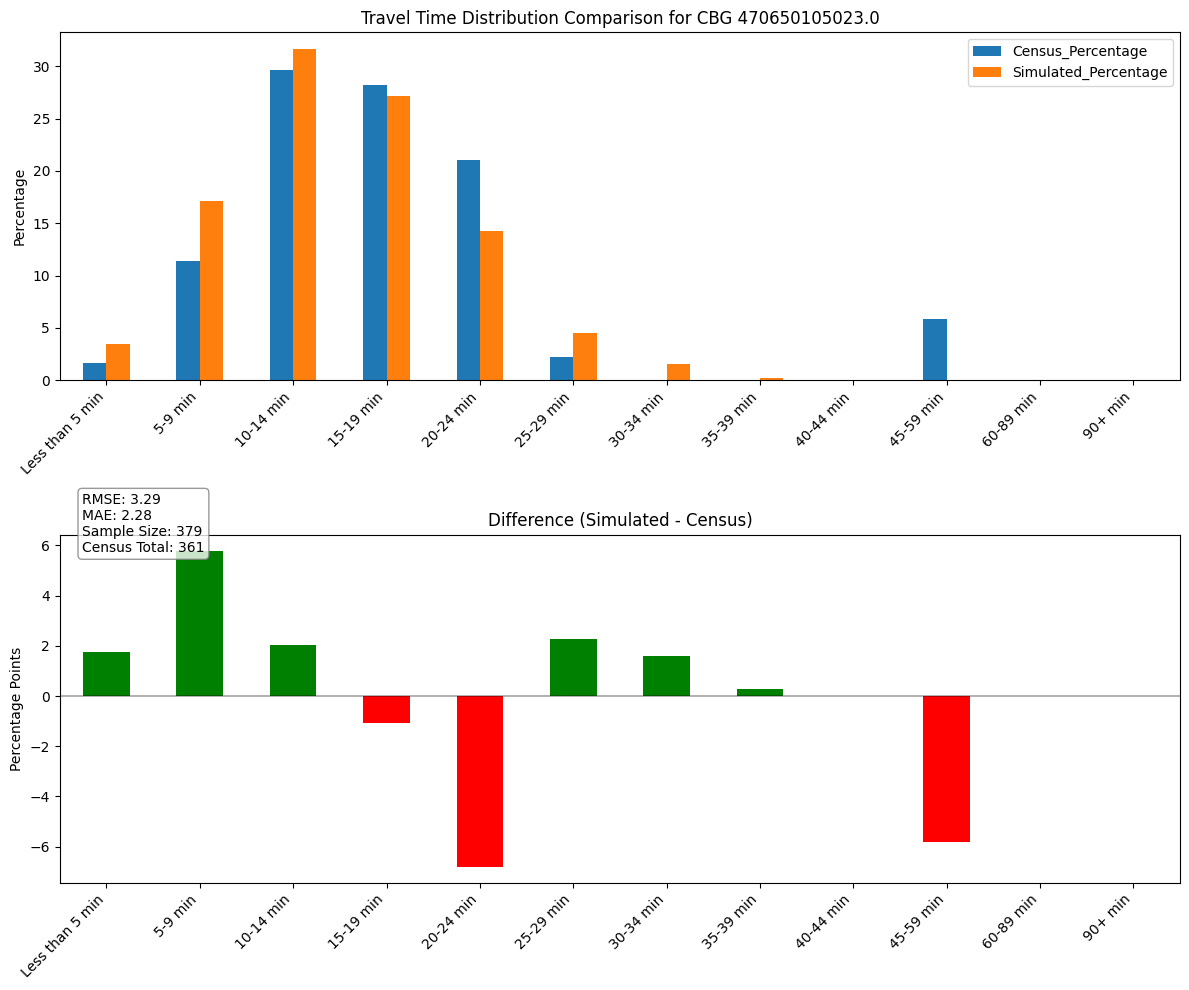

Worst matching CBG: 470650102012.0 (RMSE: 29.53)


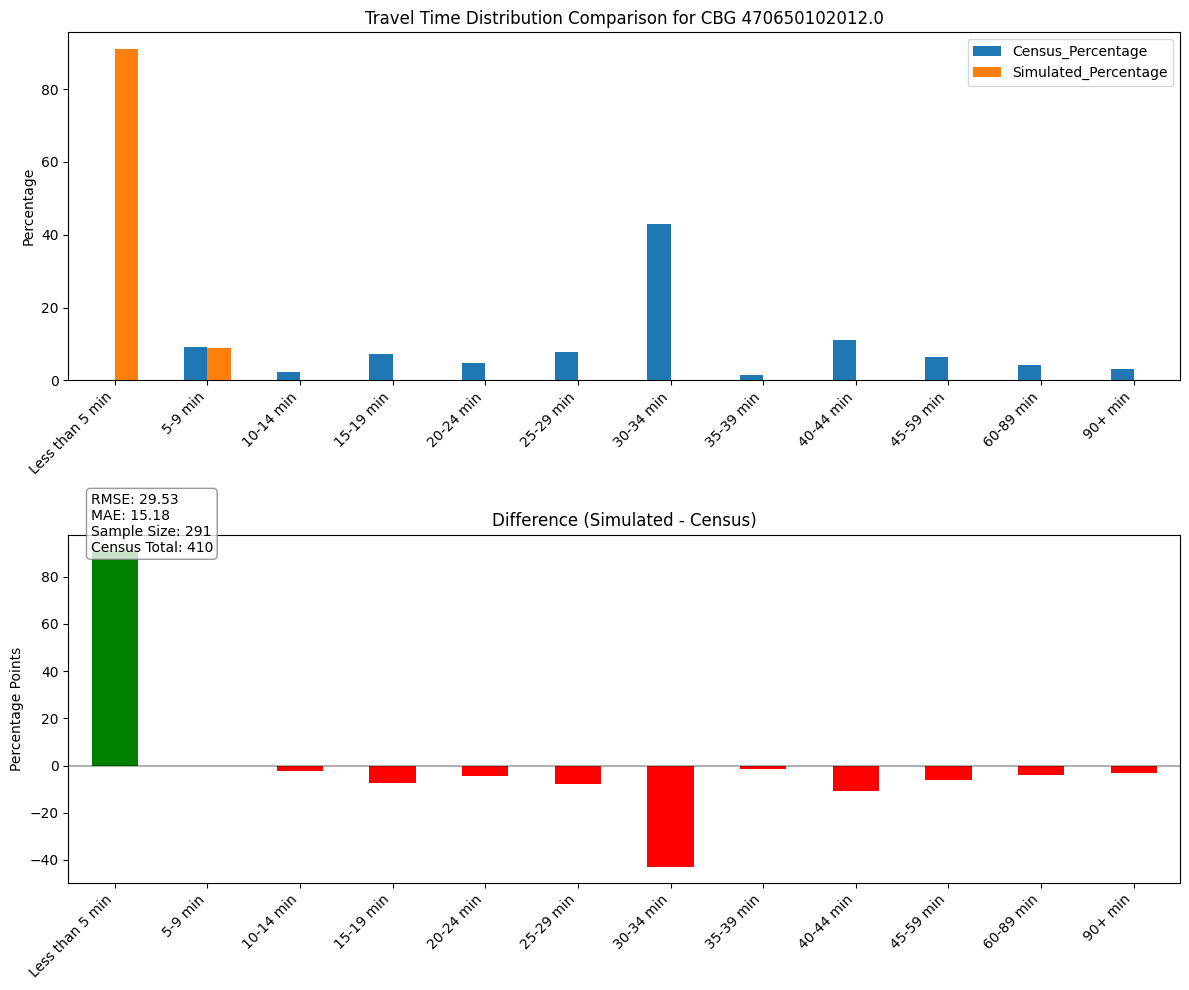

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Define the time bins and labels to match your data structure
time_columns = [
    'under_5_minutes_estimate', 
    '5_to_9_minutes_estimate', 
    '10_to_14_minutes_estimate', 
    '15_to_19_minutes_estimate', 
    '20_to_24_minutes_estimate', 
    '25_to_29_minutes_estimate',
    '30_to_34_minutes_estimate', 
    '35_to_39_minutes_estimate', 
    '40_to_44_minutes_estimate',
    '45_to_59_minutes_estimate', 
    '60_to_89_minutes_estimate', 
    '90_minutes_and_over_estimate'
]

# Corresponding bins for our routing data (in minutes)
time_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 60, 90, float('inf')]

# Pretty labels for plotting
bin_labels = [
    'Less than 5 min', '5-9 min', '10-14 min', 
    '15-19 min', '20-24 min', '25-29 min',
    '30-34 min', '35-39 min', '40-44 min',
    '45-59 min', '60-89 min', '90+ min'
]

# Prepare the travel_time_to_work_by_geoid data
# First, set GEO_ID as index for easier lookup
if travel_time_to_work_by_geoid.index.name != 'GEO_ID':
    travel_time_to_work_by_geoid = travel_time_to_work_by_geoid.set_index('GEO_ID')
    
# Calculate percentages for each CBG
for cbg_id in travel_time_to_work_by_geoid.index:
    total = travel_time_to_work_by_geoid.loc[cbg_id, 'total_estimate']
    if total > 0:  # Avoid division by zero
        for col in time_columns:
            pct_col = f"{col.replace('estimate', 'percent')}"
            travel_time_to_work_by_geoid.loc[cbg_id, pct_col] = travel_time_to_work_by_geoid.loc[cbg_id, col] / total * 100
    else:
        # If total is 0, set all percentages to 0
        for col in time_columns:
            pct_col = f"{col.replace('estimate', 'percent')}"
            travel_time_to_work_by_geoid.loc[cbg_id, pct_col] = 0

# Calculate simulated distributions by origin CBG
print("Calculating simulated travel time distributions by CBG...")

# First, make sure routing_df has travel times binned according to our bins
routing_df['time_bin'] = pd.cut(
    routing_df['travel_time_min'], 
    bins=time_bins, 
    labels=bin_labels, 
    right=False
)

# Group by origin CBG and calculate distributions
cbg_distribution_differences = {}
min_trips_threshold = 10  # Minimum trips needed for a valid comparison

for cbg_id, group_df in tqdm(routing_df.groupby('origin_geoid')):
    # Skip if not enough trips
    if len(group_df) < min_trips_threshold:
        continue
    
    # Skip if this CBG is not in the census data
    if cbg_id not in travel_time_to_work_by_geoid.index:
        continue
    
    # Calculate simulated percentages
    simulated_dist = group_df['time_bin'].value_counts(normalize=True) * 100
    
    # Create a comparison DataFrame
    comparison = pd.DataFrame(index=bin_labels)
    
    # Add simulated percentages
    comparison['Simulated_Percentage'] = [simulated_dist.get(label, 0) for label in bin_labels]
    
    # Add census percentages
    census_percentages = []
    for i, col in enumerate(time_columns):
        pct_col = f"{col.replace('estimate', 'percent')}"
        if pct_col in travel_time_to_work_by_geoid.columns:
            census_percentages.append(travel_time_to_work_by_geoid.loc[cbg_id, pct_col])
        else:
            # If column doesn't exist, calculate it on the fly
            estimate = travel_time_to_work_by_geoid.loc[cbg_id, col]
            total = travel_time_to_work_by_geoid.loc[cbg_id, 'total_estimate']
            pct = (estimate / total * 100) if total > 0 else 0
            census_percentages.append(pct)
    
    comparison['Census_Percentage'] = census_percentages
    
    # Calculate difference
    comparison['Difference'] = comparison['Simulated_Percentage'] - comparison['Census_Percentage']
    
    # Calculate metrics
    comparison['Squared_Difference'] = comparison['Difference'] ** 2
    rmse = np.sqrt(comparison['Squared_Difference'].mean())
    mae = comparison['Difference'].abs().mean()
    
    # Store results
    cbg_distribution_differences[cbg_id] = {
        'comparison': comparison,
        'rmse': rmse,
        'mae': mae,
        'sample_size': len(group_df)
    }

# Create summary dataframe
summary_rows = []
for cbg_id, data in cbg_distribution_differences.items():
    summary_rows.append({
        'CBG': cbg_id,
        'RMSE': data['rmse'],
        'MAE': data['mae'],
        'Sample_Size': data['sample_size'],
        'Census_Total': travel_time_to_work_by_geoid.loc[cbg_id, 'total_estimate']
    })

summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.sort_values('RMSE')

print(f"Analyzed {len(summary_df)} CBGs with sufficient data")
print(summary_df.head(10))  # Show top 10 CBGs with lowest RMSE

# Function to plot comparison for a specific CBG
def plot_geoid_comparison(cbg_id):
    if cbg_id not in cbg_distribution_differences:
        print(f"No comparison data available for CBG {cbg_id}")
        return None
    
    data = cbg_distribution_differences[cbg_id]
    comparison = data['comparison']
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot distributions
    comparison[['Census_Percentage', 'Simulated_Percentage']].plot(
        kind='bar',
        ax=ax1
    )
    ax1.set_title(f"Travel Time Distribution Comparison for CBG {cbg_id}")
    ax1.set_ylabel("Percentage")
    ax1.set_xticklabels(comparison.index, rotation=45, ha='right')
    
    # Plot differences
    comparison['Difference'].plot(
        kind='bar',
        color=comparison['Difference'].apply(lambda x: 'red' if x < 0 else 'green'),
        ax=ax2
    )
    ax2.set_title(f"Difference (Simulated - Census)")
    ax2.set_ylabel("Percentage Points")
    ax2.set_xticklabels(comparison.index, rotation=45, ha='right')
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Add metrics
    metrics_text = (
        f"RMSE: {data['rmse']:.2f}\n"
        f"MAE: {data['mae']:.2f}\n"
        f"Sample Size: {data['sample_size']}\n"
        f"Census Total: {travel_time_to_work_by_geoid.loc[cbg_id, 'total_estimate']}"
    )
    ax2.annotate(
        metrics_text, 
        xy=(0.02, 0.95), 
        xycoords='axes fraction',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Example: Plot the CBGs with the best and worst fit
if len(summary_df) > 0:
    best_geoid = summary_df.iloc[0]['CBG']
    worst_geoid = summary_df.iloc[-1]['CBG']
    
    print(f"Best matching CBG: {best_geoid} (RMSE: {summary_df.iloc[0]['RMSE']:.2f})")
    plot_geoid_comparison(best_geoid)
    
    print(f"Worst matching CBG: {worst_geoid} (RMSE: {summary_df.iloc[-1]['RMSE']:.2f})")
    plot_geoid_comparison(worst_geoid)

## Checks

In [71]:
import ast

def origin_in_possible_home(row):
    # Extract the origin location as a tuple
    origin = (row['origin_loc_lat'], row['origin_loc_lon'])
    # Ensure possible_home_loc is a list (if it's a string, convert it)
    possible_home = row['possible_home_loc']
    if isinstance(possible_home, str):
        possible_home = ast.literal_eval(possible_home)
    # Convert each entry in possible_home to a tuple for comparison
    possible_home_tuples = [tuple(loc) for loc in possible_home]
    return origin in possible_home_tuples

def dest_in_possible_dests(row):
    dest = (row['dest_loc_lat'], row['dest_loc_lon'])
    possible_home = row['possible_dest_loc']
    if isinstance(possible_home, str):
        possible_home = ast.literal_eval(possible_home)
    # Convert each entry in possible_home to a tuple for comparison
    possible_home_tuples = [tuple(loc) for loc in possible_home]
    return dest in possible_home_tuples

od_df['origin_in_possible_home'] = od_df.apply(origin_in_possible_home, axis=1)
od_df['dest_in_possible_dests'] = od_df.apply(dest_in_possible_dests, axis=1)

In [72]:
# Group by h_geocode and w_geocode
grouped = od_df.groupby(['h_geocode', 'w_geocode'])

# Function to check if all possible_dest_loc arrays in a group are identical
def check_identical_dests(group):
    # Convert each list of lists to a string representation for comparison
    # (directly comparing nested lists can be tricky)
    dest_strings = [str(sorted([tuple(dest) for dest in row])) for row in group['possible_dest_loc']]
    
    # Check if all are the same
    return len(set(dest_strings)) == 1

# Apply the check to each group
identical_dests_by_group = {}
for (h_code, w_code), group in grouped:
    identical_dests_by_group[(h_code, w_code)] = check_identical_dests(group)

# Count how many have identical destinations
identical_count = sum(identical_dests_by_group.values())
total_groups = len(identical_dests_by_group)

print(f"{identical_count} out of {total_groups} h_geocode, w_geocode pairs have identical possible_dest_loc lists")
print(f"Percentage: {100 * identical_count / total_groups:.2f}%")

# If you want to see groups with non-identical destinations
non_identical_groups = [(h_w, identical) for h_w, identical in identical_dests_by_group.items() if not identical]
if non_identical_groups:
    print("\nSample of groups with non-identical destinations:")
    for i, (h_w, _) in enumerate(non_identical_groups[:5]):  # Show first 5 examples
        h_code, w_code = h_w
        print(f"Group {i+1}: h_geocode={h_code}, w_geocode={w_code}")
        group = grouped.get_group((h_code, w_code))
        print(f"  Number of different records: {len(group)}")
        # Show the first few destinations from the first two records for comparison
        if len(group) >= 2:
            sample1 = group.iloc[0]['possible_dest_loc']
            sample2 = group.iloc[1]['possible_dest_loc']
            print(f"  First few destinations from record 1: {sample1[:2]}")
            print(f"  First few destinations from record 2: {sample2[:2]}")
        print()

24753 out of 24753 h_geocode, w_geocode pairs have identical possible_dest_loc lists
Percentage: 100.00%


## Calibration

In [ ]:
# import pandas as pd
# import numpy as np
# import pulp
# from tqdm.notebook import tqdm
# import matplotlib.pyplot as plt

# def calibrate_travel_times(routing_df, travel_time_to_work_by_geoid, lambda_reg=0.1):
#     """
#     Calibrate the weights of OD-S assignments to match census travel time distributions
    
#     Args:
#         routing_df: DataFrame with routing results including origin_geoid, travel_time_min
#         travel_time_to_work_by_geoid: Census travel time distributions by CBG
#         lambda_reg: Regularization parameter (higher values keep weights closer to initial)
        
#     Returns:
#         DataFrame with calibrated weights and all original fields
#     """
#     print("Starting travel time calibration process...")
    
#     # Step 1: Prepare the data
#     print("Preparing data...")
    
#     # Define time bins to match census categories
#     time_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 60, 90, float('inf')]
#     bin_names = [
#         'under_5_minutes', '5_to_9_minutes', '10_to_14_minutes', 
#         '15_to_19_minutes', '20_to_24_minutes', '25_to_29_minutes',
#         '30_to_34_minutes', '35_to_39_minutes', '40_to_44_minutes',
#         '45_to_59_minutes', '60_to_89_minutes', '90_minutes_and_over'
#     ]
    
#     # Assign each trip to a census travel time bin
#     routing_df['time_bin'] = pd.cut(routing_df['travel_time_min'], bins=time_bins, labels=False)
#     routing_df['time_bin_name'] = pd.cut(routing_df['travel_time_min'], bins=time_bins, labels=bin_names)
    
#     # Set trip indexes for the LP
#     routing_df['trip_id'] = np.arange(len(routing_df))
    
#     # Identify all unique origin CBGs
#     origins = routing_df['origin_geoid'].unique()
    
#     # Set initial equal weights within each origin CBG
#     routing_df['initial_weight'] = routing_df.groupby('origin_geoid')['trip_id'].transform(
#         lambda x: 1.0 / len(x)
#     )
    
#     # Step 2: Prepare the departure time bins (simplified - using actual 
#     # departure_time_bin from data)
#     print("Preparing departure time bins...")
#     # This assumes routing_df already has a departure_time_bin column
#     # If not available, you'd need to create it from departure_time
    
#     # Create mapping from trip_id to all its attributes for easy reference
#     trip_data = routing_df.set_index('trip_id').to_dict('index')
    
#     # Step 3: Set up the linear programming problem
#     print("Setting up the linear programming problem...")
    
#     # Initialize the problem
#     prob = pulp.LpProblem("Travel_Time_Calibration", pulp.LpMinimize)
    
#     # Step 4: Define decision variables
#     print("Defining decision variables...")
    
#     # Trip weights (x_p)
#     x = pulp.LpVariable.dicts("x", routing_df['trip_id'], lowBound=0, upBound=1)
    
#     # Slack variables for travel time bin matching (e_b^o,+/-)
#     e_plus = {}
#     e_minus = {}
    
#     for o in origins:
#         for b in range(len(bin_names)):
#             e_plus[(o, b)] = pulp.LpVariable(f"e_plus_{o}_{b}", lowBound=0)
#             e_minus[(o, b)] = pulp.LpVariable(f"e_minus_{o}_{b}", lowBound=0)
    
#     # Regularization slack variables (u_p)
#     u = pulp.LpVariable.dicts("u", routing_df['trip_id'], lowBound=0)
    
#     # Step 5: Define the objective function
#     print("Defining objective function...")
    
#     # (A) Sum of slack variables for travel time bin matching
#     bin_mismatch = pulp.lpSum([e_plus[(o, b)] + e_minus[(o, b)] 
#                               for o in origins for b in range(len(bin_names))])
    
#     # (B) Regularization term to keep weights close to initial values
#     regularization = lambda_reg * pulp.lpSum([u[p] for p in routing_df['trip_id']])
    
#     # Combined objective
#     prob += bin_mismatch + regularization
    
#     # Step 6: Define constraints
#     print("Defining constraints...")
    
#     # Get census data by origin
#     if travel_time_to_work_by_geoid.index.name != 'GEO_ID':
#         travel_time_to_work_by_geoid = travel_time_to_work_by_geoid.set_index('GEO_ID')
    
#     # Process each origin CBG
#     for o in tqdm(origins, desc="Setting up constraints by origin"):
#         # Skip if this origin isn't in census data
#         if o not in travel_time_to_work_by_geoid.index:
#             continue
            
#         # Get all trips from this origin
#         o_trips = routing_df[routing_df['origin_geoid'] == o]['trip_id'].tolist()
        
#         if not o_trips:
#             continue
            
#         # Census data for this origin
#         census_o = travel_time_to_work_by_geoid.loc[o]
        
#         # (1) Origin total flow constraint 
#         # (In this case, we normalize within each origin, so sum = 1)
#         prob += pulp.lpSum([x[p] for p in o_trips]) == 1, f"origin_total_{o}"
        
#         # Get unique departure time bins for this origin
#         dep_times = routing_df[routing_df['origin_geoid'] == o]['departure_time_bin'].unique()
        
#         # (2) Departure time distribution constraint
#         # For simplicity, we'll use uniform distribution for departure times 
#         # (you can modify to use actual time-of-day distribution if available)
#         for s in dep_times:
#             s_trips = routing_df[(routing_df['origin_geoid'] == o) & 
#                                  (routing_df['departure_time_bin'] == s)]['trip_id'].tolist()
            
#             # Uniform distribution across departure times
#             q_s_o = 1.0 / len(dep_times)  
            
#             prob += pulp.lpSum([x[p] for p in s_trips]) == q_s_o, f"dep_time_{o}_{s}"
        
#         # (3) Travel time bin matching constraint
#         for b in range(len(bin_names)):
#             # Get census proportion for this bin
#             bin_col = f"{bin_names[b]}_estimate"
            
#             # Calculate target proportion (handle missing data)
#             if bin_col in census_o.index and census_o['total_estimate'] > 0:
#                 p_b_o = census_o[bin_col] / census_o['total_estimate']
#             else:
#                 # Use default if data unavailable
#                 p_b_o = 1.0 / len(bin_names)
            
#             # Get trips from this origin in this time bin
#             b_trips = routing_df[(routing_df['origin_geoid'] == o) & 
#                                  (routing_df['time_bin'] == b)]['trip_id'].tolist()
            
#             # Sum of weights for trips in bin b = target proportion (with slack)
#             if b_trips:  # Only add constraint if we have trips in this bin
#                 prob += (pulp.lpSum([x[p] for p in b_trips]) + 
#                          e_minus[(o, b)] - e_plus[(o, b)] == p_b_o), f"bin_match_{o}_{b}"
#             else:
#                 # If no trips in this bin, slack variables must compensate exactly
#                 prob += e_minus[(o, b)] - e_plus[(o, b)] == p_b_o, f"bin_match_empty_{o}_{b}"
        
#     # (4) Regularization constraints |x_p - x_p^(0)| ≤ u_p
#     for p in routing_df['trip_id']:
#         init_weight = trip_data[p]['initial_weight']
#         # (4a) x_p - x_p^(0) ≤ u_p
#         prob += x[p] - init_weight <= u[p], f"reg_upper_{p}"
#         # (4b) x_p^(0) - x_p ≤ u_p
#         prob += init_weight - x[p] <= u[p], f"reg_lower_{p}"
    
#     # Step 7: Solve the problem
#     print("Solving the linear program...")
#     prob.solve(pulp.PULP_CBC_CMD(msg=False))
    
#     print(f"Status: {pulp.LpStatus[prob.status]}")
#     print(f"Objective Value: {pulp.value(prob.objective)}")
    
#     # Step 8: Process results
#     print("Processing results...")
    
#     # Extract calibrated weights
#     calibrated_weights = {}
#     for p in routing_df['trip_id']:
#         if pulp.value(x[p]) is not None:
#             calibrated_weights[p] = pulp.value(x[p])
#         else:
#             calibrated_weights[p] = 0.0
    
#     # Add calibrated weights to the dataframe
#     routing_df['calibrated_weight'] = routing_df['trip_id'].map(calibrated_weights)
    
#     # Normalize weights within each origin (optional, should already sum to 1)
#     routing_df['calibrated_weight_norm'] = routing_df.groupby('origin_geoid')['calibrated_weight'].transform(
#         lambda x: x / x.sum() if x.sum() > 0 else 0
#     )
    
#     # Step 9: Compare before and after distributions
#     print("Calculating improvement in distribution matching...")
    
#     # Before-after metrics
#     metrics = []
    
#     for o in origins:
#         if o not in travel_time_to_work_by_geoid.index:
#             continue
            
#         # Census distribution
#         census_o = travel_time_to_work_by_geoid.loc[o]
#         census_dist = []
        
#         for b in range(len(bin_names)):
#             bin_col = f"{bin_names[b]}_estimate"
#             if bin_col in census_o.index and census_o['total_estimate'] > 0:
#                 census_dist.append(census_o[bin_col] / census_o['total_estimate'])
#             else:
#                 census_dist.append(0)
        
#         # Initial distribution (uniform weights)
#         initial_dist = routing_df[routing_df['origin_geoid'] == o].groupby('time_bin')['initial_weight'].sum()
#         initial_dist = [initial_dist.get(b, 0) for b in range(len(bin_names))]
        
#         # Calibrated distribution
#         calibrated_dist = routing_df[routing_df['origin_geoid'] == o].groupby('time_bin')['calibrated_weight'].sum()
#         calibrated_dist = [calibrated_dist.get(b, 0) for b in range(len(bin_names))]
        
#         # Calculate errors
#         initial_rmse = np.sqrt(np.mean([(i - c)**2 for i, c in zip(initial_dist, census_dist)]))
#         calibrated_rmse = np.sqrt(np.mean([(cal - c)**2 for cal, c in zip(calibrated_dist, census_dist)]))
        
#         metrics.append({
#             'origin_geoid': o,
#             'initial_rmse': initial_rmse,
#             'calibrated_rmse': calibrated_rmse,
#             'improvement': initial_rmse - calibrated_rmse,
#             'pct_improvement': (1 - calibrated_rmse/initial_rmse)*100 if initial_rmse > 0 else 0
#         })
    
#     metrics_df = pd.DataFrame(metrics)
#     print(f"Average RMSE improvement: {metrics_df['improvement'].mean():.4f}")
#     print(f"Average percent improvement: {metrics_df['pct_improvement'].mean():.2f}%")
    
#     return routing_df, metrics_df

In [17]:
def diagnose_infeasibility(prob, routing_df, travel_time_to_work_by_geoid, od_share_df):
    """
    Diagnose why the linear programming problem is infeasible
    """
    print("Diagnosing infeasibility issues...\n")
    
    # Check 1: Missing routes for required O-D pairs
    print("CHECKING FOR MISSING O-D ROUTES:")
    missing_od_pairs = []
    
    for _, row in od_share_df.iterrows():
        o, d = row['origin_geoid'], row['destination_geoid']
        share = row['share']
        
        # If share is significant but no routes exist
        if share > 0.01:  # Only check O-D pairs with at least 1% share
            routes = routing_df[(routing_df['origin_geoid'] == o) & 
                               (routing_df['destination_geoid'] == d)]
            
            if len(routes) == 0:
                missing_od_pairs.append((o, d, share))
    
    if missing_od_pairs:
        print(f"Found {len(missing_od_pairs)} O-D pairs with significant share but no routes:")
        for o, d, share in missing_od_pairs[:10]:  # Show first 10
            print(f"  Origin {o} → Destination {d} (Share: {share:.3f})")
        if len(missing_od_pairs) > 10:
            print(f"  ... and {len(missing_od_pairs) - 10} more")
        print("\nFIX: Use od_slack=True or generate routes for these pairs")
    else:
        print("No missing O-D routes found")
    
    # Check 2: Empty travel time bins that need to match census
    print("\nCHECKING FOR MISSING TRAVEL TIME BINS:")
    missing_time_bins = []
    
    # Get unique origins
    origins = routing_df['origin_geoid'].unique()
    
    # Set up time bins
    time_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 60, 90, float('inf')]
    bin_names = [
        'under_5_minutes', '5_to_9_minutes', '10_to_14_minutes',
        '15_to_19_minutes', '20_to_24_minutes', '25_to_29_minutes',
        '30_to_34_minutes', '35_to_39_minutes', '40_to_44_minutes',
        '45_to_59_minutes', '60_to_89_minutes', '90_minutes_and_over'
    ]
    
    # Ensure index is set
    if travel_time_to_work_by_geoid.index.name != 'GEO_ID':
        travel_time_to_work_by_geoid = travel_time_to_work_by_geoid.set_index('GEO_ID')
    
    for o in origins:
        if o not in travel_time_to_work_by_geoid.index:
            continue
            
        census_o = travel_time_to_work_by_geoid.loc[o]
        
        for b, name in enumerate(bin_names):
            bin_col = f"{name}_estimate"
            if bin_col in census_o.index and census_o['total_estimate'] > 0:
                pct = census_o[bin_col] / census_o['total_estimate']
                
                # If significant share in census but no trips in simulation
                if pct > 0.10:  # More than 10% of trips
                    bin_trips = routing_df[(routing_df['origin_geoid'] == o) & 
                                          (routing_df['time_bin'] == b)]
                    
                    if len(bin_trips) == 0:
                        missing_time_bins.append((o, b, name, pct))
    
    if missing_time_bins:
        print(f"Found {len(missing_time_bins)} significant census time bins with no routes:")
        for o, b, name, pct in missing_time_bins[:10]:
            print(f"  Origin {o}, Bin {b} ({name}): {pct:.1%} of trips in census")
        if len(missing_time_bins) > 10:
            print(f"  ... and {len(missing_time_bins) - 10} more")
        print("\nFIX: Generate more routes with travel times in these bins")
    else:
        print("No major missing time bins found")
    
    # Check 3: Too restrictive constraints (overspeicifed problem)
    print("\nCHECKING FOR OVERSPECIFICATION:")
    for o in origins[:5]:  # Check a few origins
        o_trips = routing_df[routing_df['origin_geoid'] == o]
        
        # Count constraints vs variables
        n_variables = len(o_trips)
        
        # Departure time constraints
        n_dep_bins = o_trips['departure_time_bin'].nunique()
        
        # Time bin constraints 
        n_time_bins = min(12, o_trips['time_bin'].nunique())
        
        # OD constraints
        n_destinations = o_trips['destination_geoid'].nunique()
        
        # Total constraints affecting this origin
        n_constraints = 1 + n_dep_bins + n_time_bins + n_destinations  # 1 is for sum=1
        
        print(f"  Origin {o}: {n_variables} variables, ~{n_constraints} constraints")
        if n_constraints > n_variables:
            print(f"    WARNING: More constraints than variables - likely overspecified!")
    
    print("\nSUMMARY RECOMMENDATIONS:")
    print("1. If missing O-D pairs: use od_slack=True")
    print("2. If missing time bins: generate more diverse routes")
    print("3. If overspecified: relax some constraints (e.g. departure time constraints)")
    print("4. Consider using a larger regularization parameter (lambda_reg) to make the problem easier to solve")

In [18]:
import multiprocessing as mp
from functools import partial

def test_constraint_removal(name, prob):
    """Test if removing a single constraint resolves infeasibility"""
    try:
        # Create a copy of the problem without this constraint
        test_prob = prob.copy()
        del test_prob.constraints[name]
        
        # Try to solve the reduced problem
        test_prob.solve(pulp.PULP_CBC_CMD(msg=False))
        
        # If removing this constraint makes it feasible, it's part of the IIS
        if test_prob.status == pulp.LpStatusOptimal:
            # Parse constraint name to understand what it represents
            parts = name.split('_')
            constraint_info = ""
            if len(parts) > 2:
                if parts[0] == 'tt' and parts[1] == 'match':
                    constraint_info = f"Travel time bin constraint for origin {parts[2]}, bin {parts[3]}"
                elif parts[0] == 'od' and parts[1] == 'match':
                    constraint_info = f"O-D constraint for origin {parts[2]}, destination {parts[3]}"
            
            return (name, True, constraint_info)
        return (name, False, "")
    except Exception as e:
        return (name, False, f"Error: {str(e)}")

# Replace the sequential constraint testing with this parallel version
def parallel_find_infeasible_constraints(prob, max_workers=None):
    """Find infeasible constraints using parallel processing"""
    print("\nAttempting to find IIS (Irreducible Infeasible Subsystem) in parallel...")
    
    # Set number of workers (default to number of CPUs - 1)
    if max_workers is None:
        max_workers = max(1, mp.cpu_count() - 1)
    
    # Get list of all constraint names
    constraint_names = list(prob.constraints.keys())
    
    # Create a partial function with the problem fixed
    worker_func = partial(test_constraint_removal, prob=prob)
    
    # Use a process pool to parallelize constraint testing
    results = []
    with mp.Pool(processes=max_workers) as pool:
        # Show progress with tqdm if available
        try:
            from tqdm import tqdm
            for result in tqdm(pool.imap_unordered(worker_func, constraint_names), 
                              total=len(constraint_names), 
                              desc="Testing constraints"):
                if result[1]:  # If constraint removal made problem feasible
                    results.append(result)
        except ImportError:
            # Fall back to no progress bar if tqdm not available
            print(f"Testing {len(constraint_names)} constraints in parallel with {max_workers} workers...")
            results = list(pool.map(worker_func, constraint_names))
            results = [r for r in results if r[1]]
    
    # Report results
    if results:
        print(f"\nFound {len(results)} constraints that contribute to infeasibility:")
        for name, _, info in results:
            print(f"Constraint '{name}' is part of the infeasibility")
            if info:
                print(f"  {info}")
    else:
        print("\nNo single constraint removal made the problem feasible.")
        print("The infeasibility likely requires removing multiple constraints simultaneously.")
    
    return results

# Then in your main code, replace the sequential constraint testing with:
# parallel_find_infeasible_constraints(prob, max_workers=8)  # Adjust worker count as needed

In [27]:
import numpy as np
import pandas as pd
import pulp
from tqdm import tqdm

def calibrate_travel_times(
    routing_df: pd.DataFrame,
    travel_time_to_work_by_geoid: pd.DataFrame,
    od_share_df: pd.DataFrame,               # <-- NEW  (LODES shares r_od)
    lambda_reg: float = 0.1,
    od_slack: bool = False,                  # allow slack if some O-D pair has no path
    big_M: float = 1.0                       # penalty weight for optional O-D slack
):
    """
    Calibrate simulated trip weights so that they match
    (i) Census travel-time distributions,
    (ii) departure-time distributions (uniform default),
    (iii) fixed LODES origin-destination (O–D) proportions,
    while staying close to the initial uniform weights.

    Parameters
    ----------
    routing_df : DataFrame
        Must contain columns:
            • origin_geoid
            • destination_geoid          (used for O–D matching)
            • travel_time_min
            • departure_time_bin         (categorical bin already assigned)
    travel_time_to_work_by_geoid : DataFrame
        ACS travel-time histogram by CBG (columns: *_estimate, total_estimate).
    od_share_df : DataFrame   *** NEW ***
        Columns: origin_geoid, destination_geoid, share
        where `share` ∈ [0,1] and sums to 1 for each origin.
    lambda_reg : float
        ℓ₁-regularisation coefficient (keeps weights near initial).
    od_slack : bool, default False
        If True, add non-negative slack variables to (optionally) relax
        exact O–D matching when a particular (o,d) has no simulated path.
    big_M : float
        Penalty multiplier for the sum of any O–D slack variables.
    """
    # -----------------------------------------------------------
    # 0. Basic checks
    # -----------------------------------------------------------
    required_cols = {
        'origin_geoid', 'destination_geoid',
        'travel_time_min', 'departure_time_bin'
    }
    missing = required_cols - set(routing_df.columns)
    if missing:
        raise ValueError(f"routing_df missing columns: {missing}")

    if set(od_share_df.columns) != {'origin_geoid', 'destination_geoid', 'share'}:
        raise ValueError("od_share_df must have columns "
                         "['origin_geoid', 'destination_geoid', 'share'].")

    # -----------------------------------------------------------
    # 1. Pre-processing
    # -----------------------------------------------------------
    time_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 60, 90, float('inf')]
    bin_names = [
        'under_5_minutes', '5_to_9_minutes', '10_to_14_minutes',
        '15_to_19_minutes', '20_to_24_minutes', '25_to_29_minutes',
        '30_to_34_minutes', '35_to_39_minutes', '40_to_44_minutes',
        '45_to_59_minutes', '60_to_89_minutes', '90_minutes_and_over'
    ]
    routing_df['time_bin']      = pd.cut(routing_df['travel_time_min'],
                                         bins=time_bins, labels=False)
    routing_df['trip_id']       = np.arange(len(routing_df))
    routing_df['initial_weight'] = (
        routing_df.groupby('origin_geoid')['trip_id']
                  .transform(lambda x: 1.0 / len(x))
    )
    trip_data = routing_df.set_index('trip_id').to_dict('index')

    origins = routing_df['origin_geoid'].unique()
    destinations_by_o = {
        o: od_share_df.loc[od_share_df['origin_geoid'] == o,
                           'destination_geoid'].unique().tolist()
        for o in origins
    }

    # -----------------------------------------------------------
    # 2. Build the LP
    # -----------------------------------------------------------
    prob = pulp.LpProblem("Travel_Time_Calibration", pulp.LpMinimize)

    # 2.1 Decision variables
    x   = pulp.LpVariable.dicts("x", routing_df['trip_id'], 0, 1)
    u   = pulp.LpVariable.dicts("u", routing_df['trip_id'], lowBound=0)
    e_p = {}   # travel-time positive slack
    e_m = {}   # travel-time negative slack
    g_p = {}   # optional O–D positive slack
    g_m = {}   # optional O–D negative slack

    for o in origins:
        for b in range(len(bin_names)):
            e_p[(o, b)] = pulp.LpVariable(f"e_plus_{o}_{b}", lowBound=0)
            e_m[(o, b)] = pulp.LpVariable(f"e_minus_{o}_{b}", lowBound=0)
        if od_slack:
            for d in destinations_by_o[o]:
                g_p[(o, d)] = pulp.LpVariable(f"g_plus_{o}_{d}", lowBound=0)
                g_m[(o, d)] = pulp.LpVariable(f"g_minus_{o}_{d}", lowBound=0)

    # 2.2 Objective
    mismatch_tt = pulp.lpSum(e_p.values()) + pulp.lpSum(e_m.values())
    reg_term    = lambda_reg * pulp.lpSum(u.values())
    mismatch_od = 0
    if od_slack:
        mismatch_od = big_M * (pulp.lpSum(g_p.values()) + pulp.lpSum(g_m.values()))

    prob += mismatch_tt + mismatch_od + reg_term, "Total_Objective"

    # -----------------------------------------------------------
    # 3. Constraints
    # -----------------------------------------------------------
    # 3.0 index housekeeping for Census table
    if travel_time_to_work_by_geoid.index.name != 'GEO_ID':
        travel_time_to_work_by_geoid = (
            travel_time_to_work_by_geoid.set_index('GEO_ID')
        )

    for o in tqdm(origins, desc="Building constraints (per origin)"):
        o_trips = routing_df.loc[routing_df['origin_geoid'] == o, 'trip_id']
        if o_trips.empty:
            continue

        # C1 flow normalisation
        prob += pulp.lpSum(x[p] for p in o_trips) == 1, f"origin_total_{o}"

        # C2 departure-time matching (uniform)
        dep_bins = routing_df.loc[routing_df['origin_geoid'] == o,
                                  'departure_time_bin'].unique()
        q_so = 1.0 / len(dep_bins)
        for s in dep_bins:
            s_trips = routing_df.loc[
                (routing_df['origin_geoid'] == o) &
                (routing_df['departure_time_bin'] == s),
                'trip_id'
            ]
            prob += pulp.lpSum(x[p] for p in s_trips) == q_so, f"dep_match_{o}_{s}"

        # C3 travel-time distribution (with slacks)
        census_row = travel_time_to_work_by_geoid.loc[o]
        for b, name in enumerate(bin_names):
            col = f"{name}_estimate"
            p_bo = (census_row[col] / census_row['total_estimate']
                    if col in census_row and census_row['total_estimate'] > 0
                    else 1.0 / len(bin_names))
            b_trips = routing_df.loc[
                (routing_df['origin_geoid'] == o) &
                (routing_df['time_bin'] == b),
                'trip_id'
            ]
            if not b_trips.empty:
                prob += (
                    pulp.lpSum(x[p] for p in b_trips) +
                    e_m[(o, b)] - e_p[(o, b)] == p_bo
                ), f"tt_match_{o}_{b}"
            else:  # no simulated path in bin → slack absorbs target
                prob += e_m[(o, b)] - e_p[(o, b)] == p_bo, f"tt_match_empty_{o}_{b}"

        # C4 O–D distribution
        od_rows = od_share_df.loc[od_share_df['origin_geoid'] == o]
        for _, row in od_rows.iterrows():
            d, r_od = row['destination_geoid'], row['share']
            d_trips = routing_df.loc[
                (routing_df['origin_geoid'] == o) &
                (routing_df['destination_geoid'] == d),
                'trip_id'
            ]
            if not d_trips.empty:
                if od_slack:
                    prob += (
                        pulp.lpSum(x[p] for p in d_trips) +
                        g_m[(o, d)] - g_p[(o, d)] == r_od
                    ), f"od_match_{o}_{d}"
                else:
                    prob += (
                        pulp.lpSum(x[p] for p in d_trips) == r_od
                    ), f"od_match_{o}_{d}"
            else:
                if od_slack:
                    # No trip ⇒ slack must carry full target share
                    prob += g_m[(o, d)] - g_p[(o, d)] == r_od, f"od_empty_{o}_{d}"
                else:
                    raise ValueError(
                        f"No simulated path for origin {o} → destination {d}; "
                        "either generate a route or set od_slack=True."
                    )

    # C5 ℓ₁-regularisation linearisation
    for p in routing_df['trip_id']:
        w0 = trip_data[p]['initial_weight']
        prob += x[p] - w0 <= u[p], f"reg_upper_{p}"
        prob += w0 - x[p] <= u[p], f"reg_lower_{p}"

    # -----------------------------------------------------------
    # 4. Solve
    # -----------------------------------------------------------
    print("Solving LP …")
    try:
        prob.solve(pulp.PULP_CBC_CMD(msg=False))
        print(f"Status: {pulp.LpStatus[prob.status]}")
        
        if prob.status != pulp.LpStatusOptimal:
            diagnose_infeasibility(prob, routing_df, travel_time_to_work_by_geoid, od_share_df)
            
            # # If using COIN-OR CBC solver, we can get more details about infeasibility
            # print("\nAttempting to find IIS (Irreducible Infeasible Subsystem)...")
            # try:
            #     # Use parallel constraint testing to identify infeasibility sources
            #     parallel_find_infeasible_constraints(prob, max_workers=8)  # Adjust worker count as needed
            # except Exception as e:
            #     print(f"Error during parallel IIS analysis: {e}")
    except Exception as e:
        print(f"Error solving LP: {e}")
        diagnose_infeasibility(prob, routing_df, travel_time_to_work_by_geoid, od_share_df)

In [28]:

# Function to visualize results for a single CBG
def plot_calibration_results(routing_df, cbg_id, travel_time_to_work_by_geoid, bin_names):
    """
    Plot the before and after travel time distributions for a single CBG
    """
    # Filter data for this CBG
    cbg_data = routing_df[routing_df['origin_geoid'] == cbg_id]
    
    if len(cbg_data) == 0:
        print(f"No data for CBG {cbg_id}")
        return
    
    # Get census data
    if travel_time_to_work_by_geoid.index.name != 'GEO_ID':
        travel_time_to_work_by_geoid = travel_time_to_work_by_geoid.set_index('GEO_ID')
    if cbg_id not in travel_time_to_work_by_geoid.index:
        print(f"No census data for CBG {cbg_id}")
        return
        
    census_data = travel_time_to_work_by_geoid.loc[cbg_id]
    
    # Prepare census distribution
    census_dist = []
    for b in range(len(bin_names)):
        bin_col = f"{bin_names[b]}_estimate"
        if bin_col in census_data.index and census_data['total_estimate'] > 0:
            census_dist.append(census_data[bin_col] / census_data['total_estimate'])
        else:
            census_dist.append(0)
    
    # Prepare initial and calibrated distributions
    initial_dist = cbg_data.groupby('time_bin')['initial_weight'].sum()
    initial_dist = [initial_dist.get(b, 0) for b in range(len(bin_names))]
    
    calibrated_dist = cbg_data.groupby('time_bin')['calibrated_weight'].sum()
    calibrated_dist = [calibrated_dist.get(b, 0) for b in range(len(bin_names))]
    
    # Create plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    x = np.arange(len(bin_names))
    width = 0.25
    
    # Plot distributions
    ax1.bar(x - width, census_dist, width, label='Census')
    ax1.bar(x, initial_dist, width, label='Initial (Uniform)')
    ax1.bar(x + width, calibrated_dist, width, label='Calibrated')
    
    ax1.set_ylabel('Proportion')
    ax1.set_title(f'Travel Time Distribution Comparison for CBG {cbg_id}')
    ax1.set_xticks(x)
    ax1.set_xticklabels([b.replace('_', ' ').title() for b in bin_names], rotation=45, ha='right')
    ax1.legend()
    
    # Plot differences
    initial_diff = [i - c for i, c in zip(initial_dist, census_dist)]
    calibrated_diff = [cal - c for cal, c in zip(calibrated_dist, census_dist)]
    
    ax2.bar(x - width/2, calibrated_diff, width, label='Calibrated - Census')
    ax2.bar(x + width/2, initial_diff, width, label='Initial - Census')
    ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    
    ax2.set_ylabel('Difference')
    ax2.set_title('Difference from Census Distribution')
    ax2.set_xticks(x)
    ax2.set_xticklabels([b.replace('_', ' ').title() for b in bin_names], rotation=45, ha='right')
    ax2.legend()
    
    # Calculate metrics
    initial_rmse = np.sqrt(np.mean([(i - c)**2 for i, c in zip(initial_dist, census_dist)]))
    calibrated_rmse = np.sqrt(np.mean([(cal - c)**2 for cal, c in zip(calibrated_dist, census_dist)]))
    
    metrics_text = (
        f"Initial RMSE: {initial_rmse:.4f}\n"
        f"Calibrated RMSE: {calibrated_rmse:.4f}\n"
        f"Improvement: {initial_rmse - calibrated_rmse:.4f}\n"
        f"Improvement %: {(1 - calibrated_rmse/initial_rmse)*100:.2f}%"
    )
    
    ax2.annotate(
        metrics_text, 
        xy=(0.02, 0.95), 
        xycoords='axes fraction',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )
    
    plt.tight_layout()
    plt.show()
    
    return fig

In [29]:
od_pairs = routing_df[['origin_geoid', 'destination_geoid']].drop_duplicates()        
# Count trips for each OD pair
od_counts = routing_df.groupby(['origin_geoid', 'destination_geoid']).size().reset_index(name='count')

# Calculate total trips by origin
total_by_origin = od_counts.groupby('origin_geoid')['count'].sum().reset_index()
total_by_origin = dict(zip(total_by_origin['origin_geoid'], total_by_origin['count']))

# Calculate share
od_counts['share'] = od_counts.apply(
    lambda row: row['count'] / total_by_origin[row['origin_geoid']]
    if row['origin_geoid'] in total_by_origin and total_by_origin[row['origin_geoid']] > 0
    else 0,
    axis=1
)

# Create final dataframe
od_share_df = od_counts[['origin_geoid', 'destination_geoid', 'share']]


In [30]:
bin_names = [
    'under_5_minutes', '5_to_9_minutes', '10_to_14_minutes',
    '15_to_19_minutes', '20_to_24_minutes', '25_to_29_minutes',
    '30_to_34_minutes', '35_to_39_minutes', '40_to_44_minutes',
    '45_to_59_minutes', '60_to_89_minutes', '90_minutes_and_over'
]

od_share_df

calibrated_df, metrics_df = calibrate_travel_times(routing_df, travel_time_to_work_by_geoid, od_share_df, lambda_reg=0.00001, od_slack=False, big_M=np.inf)

Building constraints (per origin): 100%|██████████| 255/255 [00:06<00:00, 42.05it/s]


Solving LP …
Status: Infeasible
Diagnosing infeasibility issues...

CHECKING FOR MISSING O-D ROUTES:
No missing O-D routes found

CHECKING FOR MISSING TRAVEL TIME BINS:
Found 43 significant census time bins with no routes:
  Origin 470650104114, Bin 9 (45_to_59_minutes): 20.4% of trips in census
  Origin 470650102012, Bin 6 (30_to_34_minutes): 42.9% of trips in census
  Origin 470650102012, Bin 8 (40_to_44_minutes): 11.0% of trips in census
  Origin 470650116002, Bin 9 (45_to_59_minutes): 21.7% of trips in census
  Origin 470650113213, Bin 10 (60_to_89_minutes): 10.6% of trips in census
  Origin 470650118005, Bin 9 (45_to_59_minutes): 14.0% of trips in census
  Origin 470650118006, Bin 7 (35_to_39_minutes): 11.2% of trips in census
  Origin 470650019001, Bin 9 (45_to_59_minutes): 22.2% of trips in census
  Origin 470650031001, Bin 10 (60_to_89_minutes): 15.1% of trips in census
  Origin 470650114135, Bin 8 (40_to_44_minutes): 15.8% of trips in census
  ... and 33 more

FIX: Generate mo

TypeError: cannot unpack non-iterable NoneType object

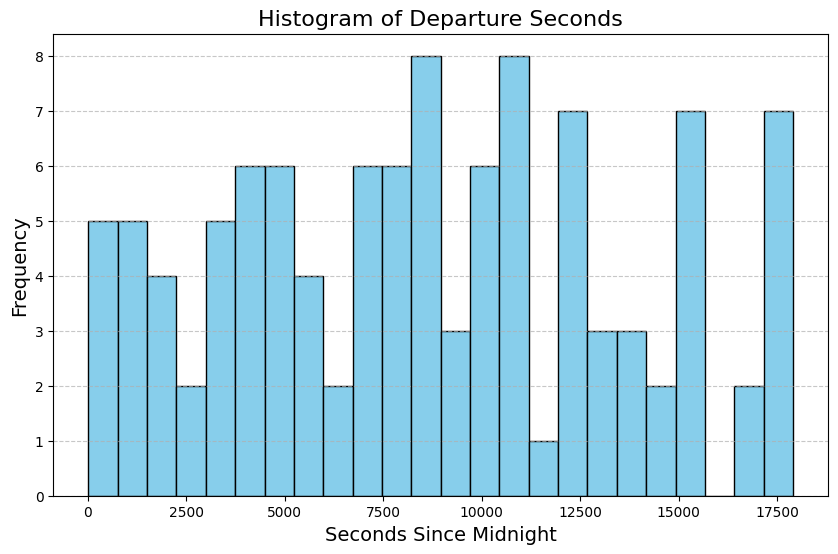

In [48]:
import matplotlib.pyplot as plt

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(od_df[od_df['h_geocode'] == 470650114461]['departure_time_secs'], bins=24, color='skyblue', edgecolor='black')
plt.title('Histogram of Departure Seconds', fontsize=16)
plt.xlabel('Seconds Since Midnight', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [44]:
# Loop through all unique origin_geoids and compute coverage
all_coverage = {}

for o in routing_df['origin_geoid'].unique():
    coverage = routing_df[routing_df.origin_geoid == o] \
        .groupby(['departure_time_bin', 'destination_geoid']) \
        .size().unstack(fill_value=0)
    all_coverage[o] = coverage

# Example: Access coverage for a specific origin_geoid
example_origin_geoid = list(all_coverage.keys())[-1]
print(f"Coverage for origin_geoid {example_origin_geoid}:")
all_coverage[470650114461]

Coverage for origin_geoid 470650121004:


destination_geoid,470650004002,470650006001,470650008001,470650012001,470650012002,470650012003,470650013002,470650016002,470650016003,470650018001,...,470650121005,470650122001,470650123001,470650123003,470650124001,470650124002,470650124003,470650124004,470659801001,470659802001
departure_time_bin,,,,,,,,,,,,,,,,,,,,,
0,23,0,0,0,7,16,2,0,5,1,...,1,2,1,3,1,4,2,2,4,27
1,20,0,2,1,1,14,0,0,4,1,...,1,2,1,5,3,4,0,1,3,24
2,29,1,1,2,4,16,0,1,8,2,...,0,0,0,6,4,3,1,0,3,17
3,37,1,1,1,4,14,2,3,6,0,...,0,0,2,3,0,3,1,0,3,25
4,20,2,0,0,8,17,0,0,5,0,...,2,0,0,7,1,2,0,1,3,24


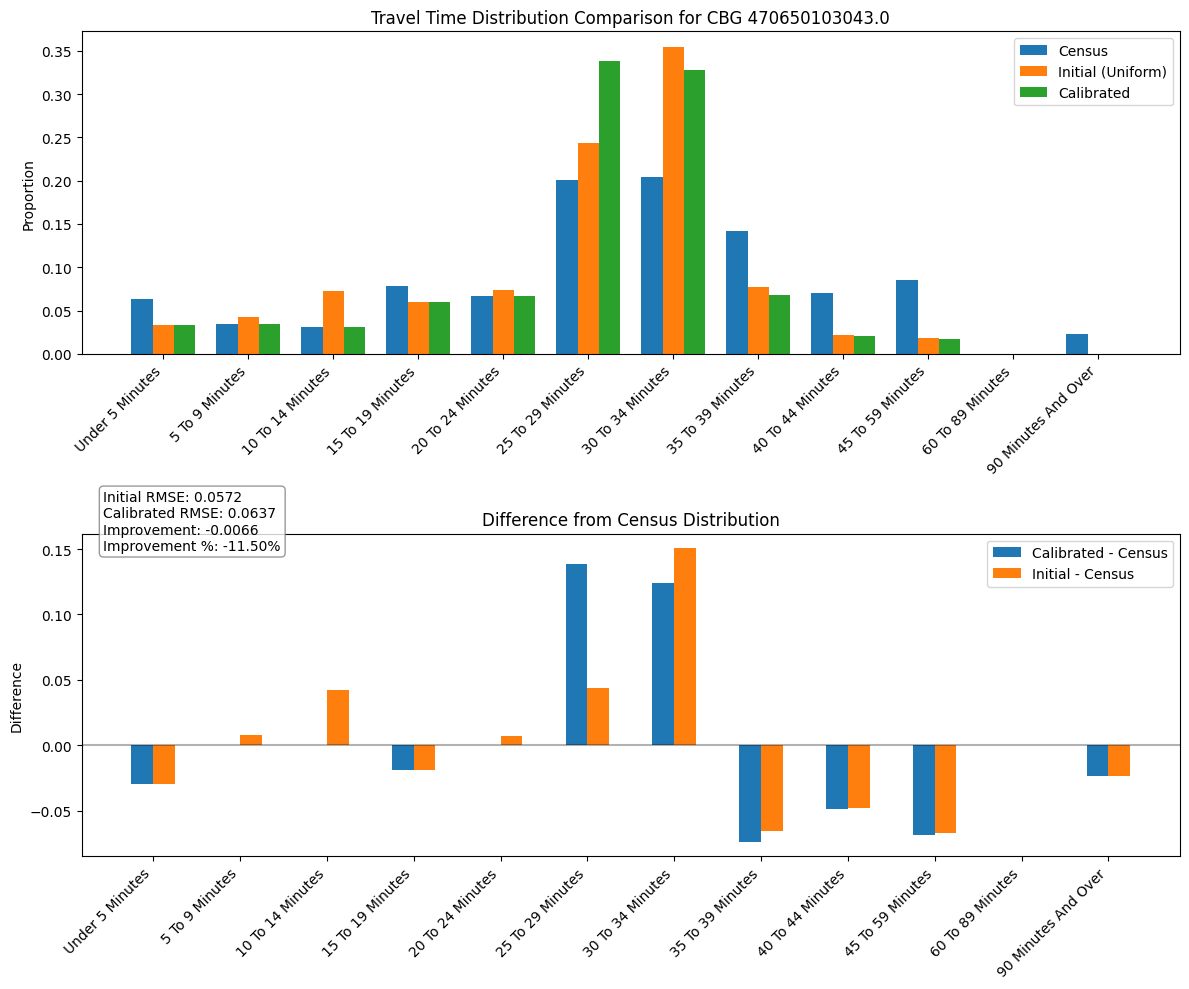

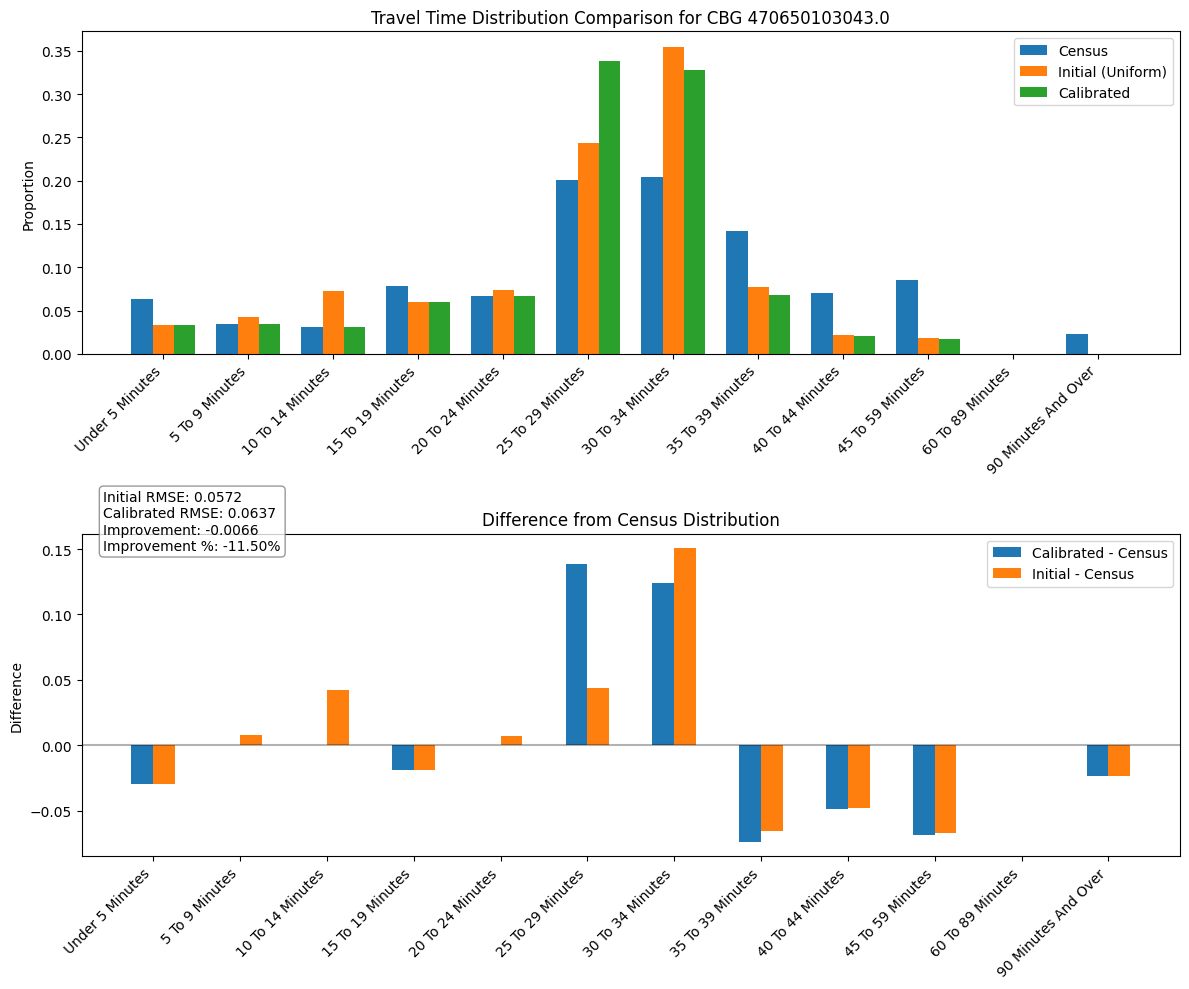

In [23]:
# best_cbg = metrics_df.sort_values('pct_improvement', ascending=False).iloc[0]['origin_geoid']
# plot_calibration_results(calibrated_df, best_cbg, travel_time_to_work_by_geoid, bin_names)
best_cbg = metrics_df.sort_values('pct_improvement', ascending=False).iloc[-4]['origin_geoid']
plot_calibration_results(calibrated_df, best_cbg, travel_time_to_work_by_geoid, bin_names)

Aggregating data from 255 CBGs...


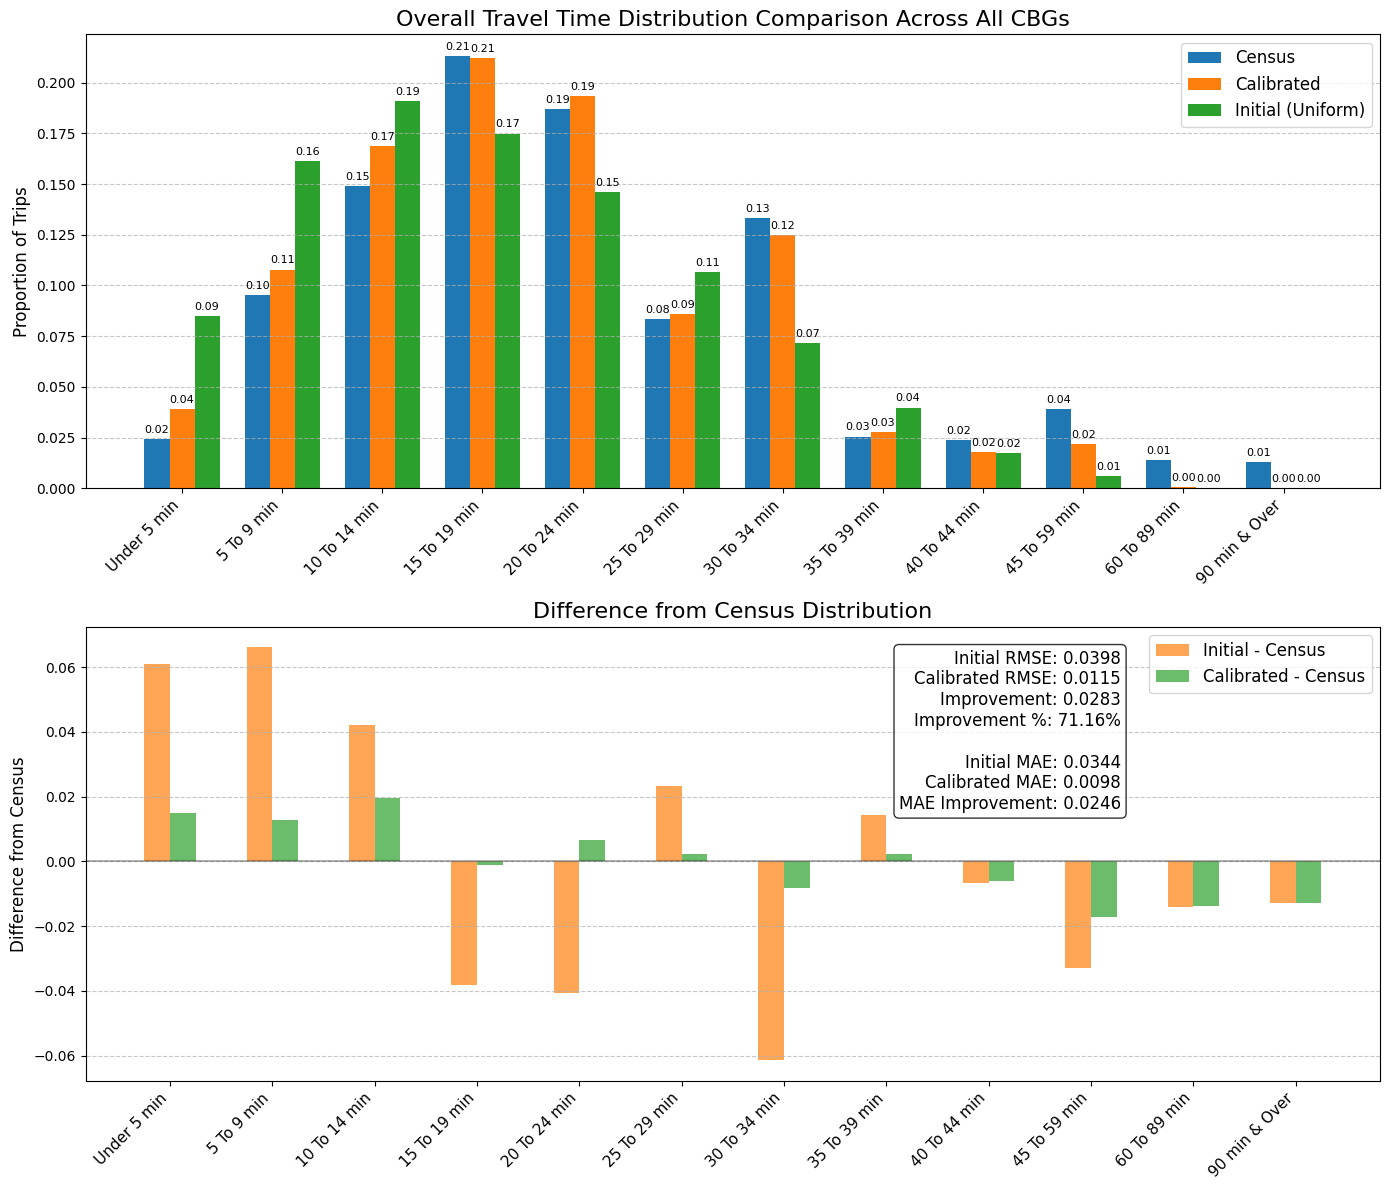

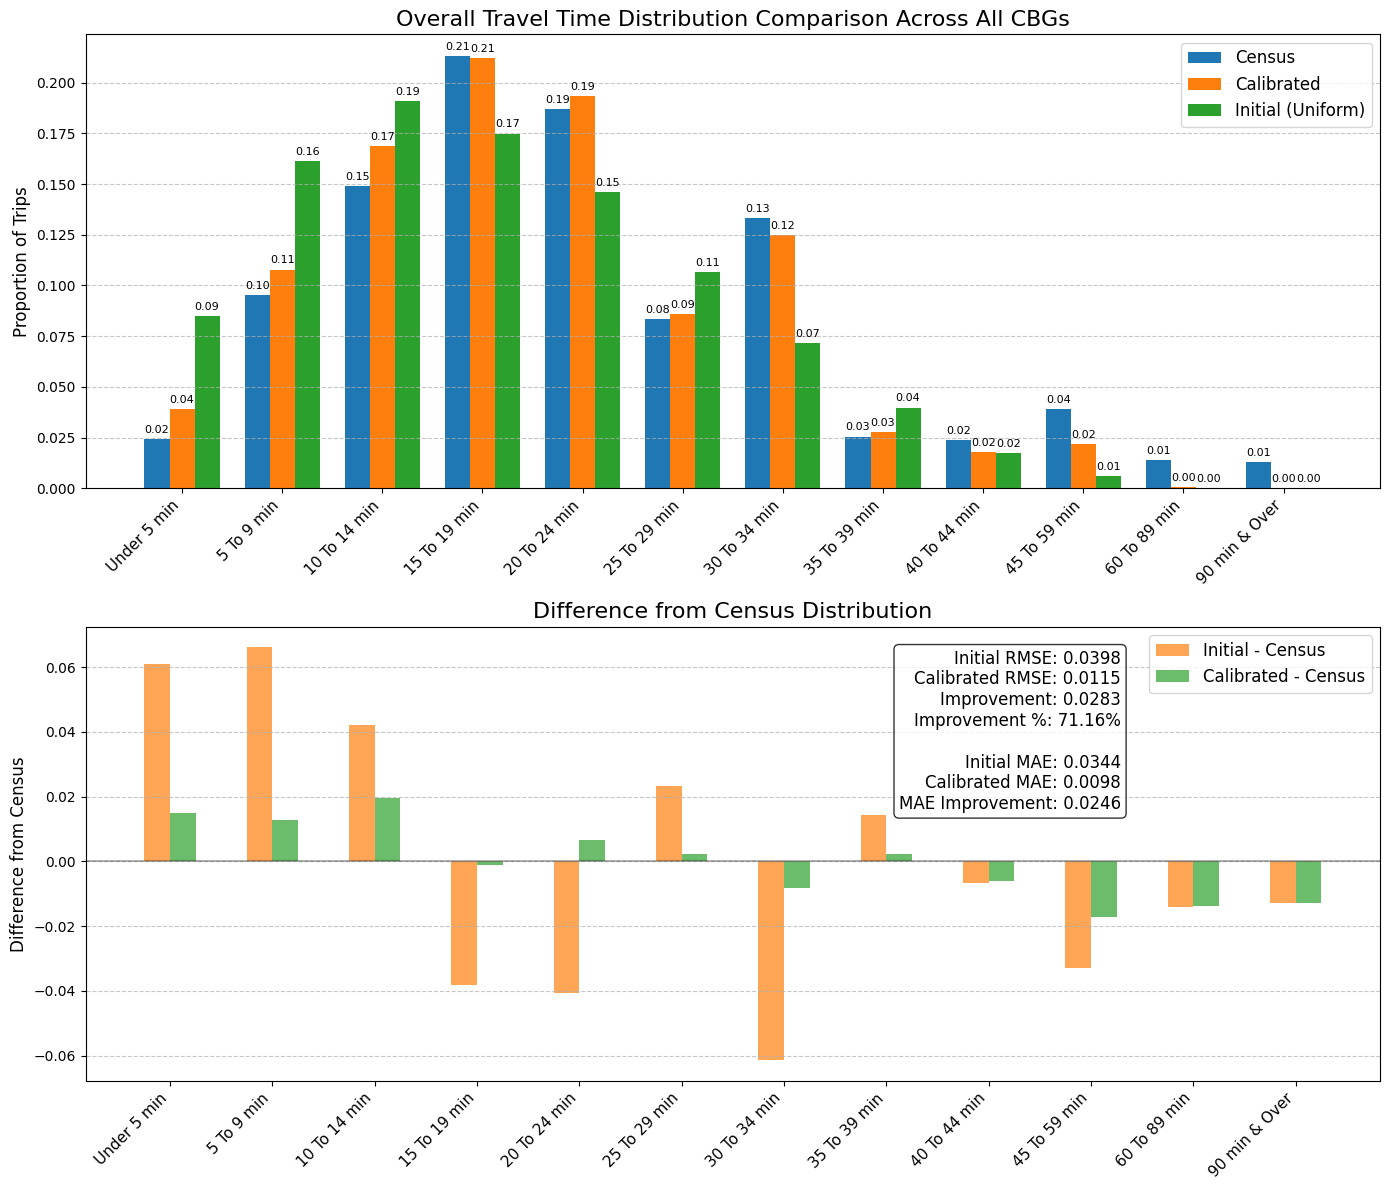

In [24]:
def plot_overall_calibration_results(routing_df, travel_time_to_work_by_geoid, bin_names):
    """
    Create an overall plot showing the travel time distributions 
    across all CBGs before and after calibration.
    
    Args:
        routing_df: DataFrame with routing results and calibrated weights
        travel_time_to_work_by_geoid: Census travel time distributions by CBG
        bin_names: Names of travel time bins matching census categories
    
    Returns:
        matplotlib figure
    """
    # Set up time bin labels for display
    display_labels = [b.replace('_', ' ').title().replace('And', '&') for b in bin_names]
    display_labels = [b.replace('Minutes', 'min') for b in display_labels]
    
    # Initialize arrays to store aggregated distributions
    census_dist = np.zeros(len(bin_names))
    initial_dist = np.zeros(len(bin_names))
    calibrated_dist = np.zeros(len(bin_names))
    
    # Get unique origins with data in both routing and census
    origins = routing_df['origin_geoid'].unique()

    if travel_time_to_work_by_geoid.index.name != 'GEO_ID':
        travel_time_to_work_by_geoid = travel_time_to_work_by_geoid.set_index('GEO_ID')
    valid_origins = [o for o in origins if o in travel_time_to_work_by_geoid.index]
    
    print(f"Aggregating data from {len(valid_origins)} CBGs...")
    
    # Total trips/commuters for normalization
    total_census_trips = 0
    
    # Calculate weighted average distributions
    for o in valid_origins:
        # Get census data
        census_o = travel_time_to_work_by_geoid.loc[o]
        if census_o['total_estimate'] <= 0:
            continue
            
        # Weight by total number of commuters in this CBG
        cbg_weight = census_o['total_estimate']
        total_census_trips += cbg_weight
        
        # Add to census distribution
        for b in range(len(bin_names)):
            bin_col = f"{bin_names[b]}_estimate"
            if bin_col in census_o.index:
                census_dist[b] += census_o[bin_col]
    
    # Normalize census distribution
    if total_census_trips > 0:
        census_dist = census_dist / total_census_trips
    
    # For routing data, aggregate across all trips
    for b in range(len(bin_names)):
        # Get all trips in this time bin
        bin_trips = routing_df[routing_df['time_bin'] == b]
        
        # Sum initial weights
        initial_dist[b] = bin_trips['initial_weight'].sum()
        
        # Sum calibrated weights
        calibrated_dist[b] = bin_trips['calibrated_weight'].sum()
    
    # Normalize routing distributions
    initial_dist = initial_dist / initial_dist.sum() if initial_dist.sum() > 0 else initial_dist
    calibrated_dist = calibrated_dist / calibrated_dist.sum() if calibrated_dist.sum() > 0 else calibrated_dist
    
    # Create the figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
    
    x = np.arange(len(bin_names))
    width = 0.25
    
    # Plot distributions
    bars1 = ax1.bar(x - width, census_dist, width, label='Census', color='#1f77b4')
    bars2 = ax1.bar(x, calibrated_dist, width, label='Calibrated', color='#ff7f0e')
    bars3 = ax1.bar(x + width, initial_dist, width, label='Initial (Uniform)', color='#2ca02c')
    
    ax1.set_ylabel('Proportion of Trips', fontsize=12)
    ax1.set_title('Overall Travel Time Distribution Comparison Across All CBGs', fontsize=16)
    ax1.set_xticks(x)
    ax1.set_xticklabels(display_labels, rotation=45, ha='right', fontsize=11)
    ax1.legend(fontsize=12)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add data labels on bars
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax1.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=8,
                        rotation=0)  # Rotate text by 456 degrees (equivalent to 96 degrees)
    
    add_labels(bars1)
    add_labels(bars2)
    add_labels(bars3)
    
    # Plot differences
    initial_diff = initial_dist - census_dist
    calibrated_diff = calibrated_dist - census_dist
    
    bars4 = ax2.bar(x - width/2, initial_diff, width, label='Initial - Census', color='#ff7f0e', alpha=0.7)
    bars5 = ax2.bar(x + width/2, calibrated_diff, width, label='Calibrated - Census', color='#2ca02c', alpha=0.7)
    ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    
    ax2.set_ylabel('Difference from Census', fontsize=12)
    ax2.set_title('Difference from Census Distribution', fontsize=16)
    ax2.set_xticks(x)
    ax2.set_xticklabels(display_labels, rotation=45, ha='right', fontsize=11)
    ax2.legend(fontsize=12)
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Calculate overall metrics
    initial_rmse = np.sqrt(np.mean((initial_dist - census_dist) ** 2))
    calibrated_rmse = np.sqrt(np.mean((calibrated_dist - census_dist) ** 2))
    initial_mae = np.mean(np.abs(initial_dist - census_dist))
    calibrated_mae = np.mean(np.abs(calibrated_dist - census_dist))
    
    # Add metrics as text
    metrics_text = (
        f"Initial RMSE: {initial_rmse:.4f}\n"
        f"Calibrated RMSE: {calibrated_rmse:.4f}\n"
        f"Improvement: {initial_rmse - calibrated_rmse:.4f}\n"
        f"Improvement %: {(1 - calibrated_rmse/initial_rmse)*100:.2f}%\n\n"
        f"Initial MAE: {initial_mae:.4f}\n"
        f"Calibrated MAE: {calibrated_mae:.4f}\n"
        f"MAE Improvement: {initial_mae - calibrated_mae:.4f}"
    )
    
    # Place text box in upper right corner
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    ax2.text(0.8, 0.95, metrics_text, transform=ax2.transAxes, fontsize=12,
            verticalalignment='top', horizontalalignment='right', bbox=props)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Example usage:
# bin_names = [
#     'under_5_minutes', '5_to_9_minutes', '10_to_14_minutes', 
#     '15_to_19_minutes', '20_to_24_minutes', '25_to_29_minutes',
#     '30_to_34_minutes', '35_to_39_minutes', '40_to_44_minutes',
#     '45_to_59_minutes', '60_to_89_minutes', '90_minutes_and_over'
# ]
# 
# # After running calibration:
plot_overall_calibration_results(calibrated_df, travel_time_to_work_by_geoid, bin_names)

In [27]:
calibrated_df.drop(['route_nodes'], axis=1).to_csv('calibrated_df.csv')

## Calibration

In [58]:
census_travel_time_df = pd.read_csv('../move_OD/Hamilton_Tennessee_2024-03-23_2024-03-23/census_data/travel_time_to_work.csv', index_col=0)

census_df = census_travel_time_df.copy()

time_bins_columns = [
    'under_5_minutes_estimate', '5_to_9_minutes_estimate',
    '10_to_14_minutes_estimate', '15_to_19_minutes_estimate',
    '20_to_24_minutes_estimate', '25_to_29_minutes_estimate',
    '30_to_34_minutes_estimate', '35_to_39_minutes_estimate',
    '40_to_44_minutes_estimate', '45_to_59_minutes_estimate',
    '60_to_89_minutes_estimate', '90_minutes_and_over_estimate'
]

# Create structured census_targets dict
census_targets = {}
for _, row in census_df.iterrows():
    geo_id = row['GEO_ID']
    total_estimate = row['total_estimate']
    if total_estimate == 0:
        continue  # skip no data
    census_targets[geo_id] = {col: row[col]/total_estimate for col in time_bins_columns}


census_bin_edges = [0,5,10,15,20,25,30,35,40,45,60,90,float('inf')]
census_bin_labels = time_bins_columns

In [59]:
# Create mapping from time bins to hours
time_bin_to_hour = {}
for hour in hourly_graphs.keys():
    # Convert hour to seconds since midnight
    seconds_since_midnight = hour.hour * 3600 + hour.minute * 60 + hour.second
    # Calculate bin number (assuming 1-hour bins)
    bin_number = seconds_since_midnight // 3600
    # Store the mapping
    time_bin_to_hour[bin_number] = hour

In [60]:
od_total_jobs = od_df.groupby(['h_geocode', 'w_geocode']).count()['total_jobs'].reset_index()
cbg_pairs = od_df.drop_duplicates(subset=['h_geocode', 'w_geocode'])[['h_geocode', 'w_geocode']]
cbg_pairs = cbg_pairs.merge(od_total_jobs, on=['h_geocode', 'w_geocode'])

In [61]:
# import numpy as np

# def lookup_travel_time(row):
#     matrix_df = travel_time_matrix[int(row['departure_time_secs'] // 1800)]
#     match = matrix_df[
#         (matrix_df['origin'] == row['origin_node']) &
#         (matrix_df['destination'] == row['destination_node'])
#     ]
#     if not match.empty:
#         return match.iloc[0]['travel_time_min']
#     else:
#         return np.nan

# od_df['travel_time_inrix'] = od_df.apply(lookup_travel_time, axis=1)

In [62]:
def get_census_target(row):
    geo_id = row['origin_cbg']
    bin_label = row['census_bin']
    return census_targets.get(geo_id, {}).get(bin_label, 0)

In [ ]:
# import pandas as pd
# import numpy as np
# import ast
# import osmnx as ox

# def expand_od_candidates(od_df, G_0, travel_time_matrix_idx, departure_interval=3600):
#     records = []

#     for _, row in tqdm(od_df.iterrows(), total=len(od_df), desc="Expanding OD candidates"):
#         origin_cbg = row['h_geocode']
#         destination_cbg = row['w_geocode']
#         departure_time = row['departure_time_secs']
#         departure_time_bin = departure_time // departure_interval

#         # Parse possible origins and destinations
#         possible_home = row['possible_home_loc']
#         possible_dest = row['possible_dest_loc']

#         if isinstance(possible_home, str):
#             possible_home = ast.literal_eval(possible_home)
#         if isinstance(possible_dest, str):
#             possible_dest = ast.literal_eval(possible_dest)

#         try:
#             origin_nodes = ox.distance.nearest_nodes(G_0, X=[lon for _, lon in possible_home], Y=[lat for lat, _ in possible_home])
#             dest_nodes = ox.distance.nearest_nodes(G_0, X=[lon for _, lon in possible_dest], Y=[lat for lat, _ in possible_dest])
#         except Exception as e:
#             continue

#         travel_time_matrix = travel_time_matrix_idx.get(departure_time_bin)
#         if travel_time_matrix is None:
#             continue

#         for o_node in origin_nodes:
#             for d_node in dest_nodes:
#                 match = travel_time_matrix[
#                     (travel_time_matrix['origin'] == o_node) &
#                     (travel_time_matrix['destination'] == d_node)
#                 ]
#                 if match.empty:
#                     print(f"Nodes not found in travel_time_matrix at {departure_time_bin}, {o_node}, {d_node}")
#                     t_min = np.nan
#                 else:
#                     t_min = match['travel_time_min'].iloc[0]
                    
#                 records.append({
#                     'origin_cbg': origin_cbg,
#                     'destination_cbg': destination_cbg,
#                     'origin_node': o_node,
#                     'destination_node': d_node,
#                     'departure_time_bin': departure_time_bin,
#                     'travel_time': t_min
#                 })

#     return pd.DataFrame(records)


In [ ]:
import pandas as pd
import numpy as np
import ast
import osmnx as ox
from tqdm.notebook import tqdm
import multiprocessing as mp

def process_chunk(args):
    """Process a chunk of OD pairs using pre-computed travel time lookup"""
    chunk_df, travel_time_lookup, time_bin_to_hour, census_bins, census_targets = args
    records = []
    
    for _, row in chunk_df.iterrows():
        origin_cbg = row['h_geocode']
        destination_cbg = row['w_geocode']
        departure_time = row['departure_time_secs']
        departure_time_bin = departure_time // 3600  # Assumes 1-hour bins
        
        # Get the appropriate hour for this time bin
        hour = time_bin_to_hour.get(departure_time_bin)
        if hour is None:
            continue
            
        # Get the travel time lookup for this hour
        matrix = travel_time_lookup.get(hour)
        if matrix is None:
            continue
        
        # Parse possible origins and destinations
        origin_nodes = row['possible_home_loc']
        dest_nodes = row['possible_dest_loc']
        
        if isinstance(origin_nodes, str):
            origin_nodes = ast.literal_eval(origin_nodes)
        if isinstance(dest_nodes, str):
            dest_nodes = ast.literal_eval(dest_nodes)
        
        try:
            # Use the pre-computed travel time matrix
            for o_node in origin_nodes:
                for d_node in dest_nodes:
                    # Fast dictionary lookup
                    travel_time_min = matrix.get((o_node, d_node))
                    if travel_time_min is not None:
                        # Determine census bin for this travel time
                        census_bin = None
                        for i, (lower, upper) in enumerate(zip(census_bins[:-1], census_bins[1:])):
                            if lower <= travel_time_min < upper:
                                census_bin = i
                                break
                        
                        # Get target proportion for this bin
                        target = census_targets.get(census_bin, 0) if census_bin is not None else 0
                        
                        records.append({
                            'origin_cbg': origin_cbg,
                            'destination_cbg': destination_cbg,
                            'origin_node': o_node,
                            'destination_node': d_node, 
                            'departure_time_bin': departure_time_bin,
                            'travel_time': travel_time_min,
                            'census_bin': census_bin,
                            'census_target': target
                        })
        except Exception as e:
            continue
            
    return records

def expand_od_candidates_parallel(od_df, travel_time_lookup, time_bin_to_hour, 
                                 census_bins, census_targets, n_jobs=None):
    """Use pre-computed travel times with parallel processing"""
    if n_jobs is None:
        n_jobs = max(1, mp.cpu_count() - 1)
    
    # Split dataframe into chunks for parallelism
    chunk_size = max(1, len(od_df) // (n_jobs * 10))
    chunks = [od_df.iloc[i:i+chunk_size] for i in range(0, len(od_df), chunk_size)]
    
    # Prepare arguments for each worker
    args_list = [(chunk, travel_time_lookup, time_bin_to_hour, 
                  census_bins, census_targets) for chunk in chunks]
    
    # Process in parallel
    all_records = []
    with mp.Pool(n_jobs) as pool:
        for chunk_records in tqdm(
            pool.imap(process_chunk, args_list),
            total=len(args_list),
            desc="Processing OD chunks"
        ):
            all_records.extend(chunk_records)
    
    return pd.DataFrame(all_records)

In [74]:
def assign_bins_and_targets(df, bin_edges, bin_labels, census_target_lookup):
    df = df.copy()
    df['census_bin'] = pd.cut(df['travel_time'], bins=bin_edges, labels=bin_labels, right=False)
    df['initial_weight'] = 1 / len(df)

    def get_target(row):
        return census_target_lookup.get(row['origin_cbg'], {}).get(row['census_bin'], 0)

    df['census_target'] = df.apply(get_target, axis=1)
    return df

In [75]:
from tqdm import tqdm
import cvxpy as cp

def calibrate_weights(calibration_df, lambda_reg=1.0):
    calibrated_sub_dfs = []
    calibration_df = calibration_df.dropna(subset=['travel_time', 'census_target'])

    for origin_cbg, group in tqdm(calibration_df.groupby('origin_cbg'), desc="Calibrating per origin"):
        n = len(group)
        if n == 0:
            continue

        x = cp.Variable(n, nonneg=True)
        unique_bins = group['census_bin'].unique()
        bin_indices = {b: group[group['census_bin'] == b].index.tolist() for b in unique_bins}
        e_plus = cp.Variable(len(unique_bins), nonneg=True)
        e_minus = cp.Variable(len(unique_bins), nonneg=True)

        constraints = [cp.sum(x) == 1]
        for i, b in enumerate(unique_bins):
            idxs = group.index.get_indexer(bin_indices[b])
            if len(idxs) == 0:
                continue
            census_prop = group.loc[bin_indices[b][0], 'census_target']
            constraints.append(cp.sum(x[idxs]) - census_prop == e_plus[i] - e_minus[i])

        initial_w = group['initial_weight'].values
        objective = cp.Minimize(cp.sum(e_plus + e_minus) + lambda_reg * cp.norm1(x - initial_w))

        prob = cp.Problem(objective, constraints)
        try:
            prob.solve(solver=cp.ECOS, verbose=False)
        except cp.error.SolverError:
            continue

        group = group.copy()
        group['optimized_weight'] = x.value if x.value is not None else np.nan
        calibrated_sub_dfs.append(group)

    return pd.concat(calibrated_sub_dfs, ignore_index=True)


In [76]:
def sample_calibrated_od(calibrated_df):
    sampled = []
    
    grouped = calibrated_df.groupby(
        ['origin_cbg', 'destination_cbg', 'departure_time_bin']
    )
    for _, group in tqdm(
        grouped, total=grouped.ngroups, desc="Sampling calibrated OD"
    ):
        probs = group['optimized_weight'].fillna(0).values
        probs /= probs.sum() if probs.sum() > 0 else 1

        idx = np.random.choice(group.index, p=probs)
        sampled.append(group.loc[idx])

    return pd.DataFrame(sampled)

In [77]:
def run_full_calibration_pipeline(od_df, time_bin_to_hour, census_bin_edges, travel_time_matrix, census_targets, departure_interval=3600):
    print("🔁 Expanding OD candidates...")
    expanded_df = expand_od_candidates_parallel(od_df, travel_time_matrix,time_bin_to_hour, census_bin_edges, census_targets)

    print("🧮 Assigning travel-time bins and census targets...")
    expanded_df = assign_bins_and_targets(expanded_df, census_bin_edges, census_bin_labels, census_targets)

    print("📉 Solving LPs for calibration...")
    calibrated_df = calibrate_weights(expanded_df)

    print("🎲 Sampling final calibrated OD locations...")
    final_sampled = sample_calibrated_od(calibrated_df)

    return final_sampled


In [ ]:
final_calibrated_od = run_full_calibration_pipeline(
    od_df=od_df,
    time_bin_to_hour=time_bin_to_hour,
    census_bin_edges=census_bin_edges,
    travel_time_matrix=travel_time_matrix,
    census_targets=census_targets
)

🔁 Expanding OD candidates...


Processing OD chunks:   0%|          | 0/314 [00:00<?, ?it/s]IOStream.flush timed out

In [65]:
# Specify the origin and destination nodes
origin_node, destination_node = 202671398, 202608340

# Specify the hour (e.g., 0 for the first hour)
hour = 2

# Access the travel time matrix for the specified hour
hour_matrix = travel_time_matrix[hour]

# Filter for the specific origin and destination pair
result = hour_matrix[
    (hour_matrix['origin'] == origin_node) &
    (hour_matrix['destination'] == destination_node)
]

# Display the result
if not result.empty:
    print("Found the origin-destination pair:")
    print(result)
else:
    print("The specified origin-destination pair was not found.")

Found the origin-destination pair:
             origin  destination  travel_time_min                hour
77223755  202671398    202608340        19.449052 2025-03-10 02:00:00


## Old

In [ ]:
calibration_df.to_csv('calibration_df.csv')

In [ ]:
import cvxpy as cp

optimized_weights_list = []

for origin_cbg, df_origin in calibration_df.groupby('origin_cbg'):
    x = cp.Variable(len(df_origin), nonneg=True)

    # Slack variables for each bin
    bins = df_origin['census_bin'].unique()
    e_plus = cp.Variable(len(bins), nonneg=True)
    e_minus = cp.Variable(len(bins), nonneg=True)

    # Regularization parameter
    lambda_reg = 1.0

    # Objective
    objective = cp.Minimize(
        cp.sum(e_plus + e_minus) + lambda_reg * cp.norm1(x - df_origin['initial_weight'].values)
    )

    # Constraints
    constraints = [
        cp.sum(x) == 1  # Exactly one trip per origin CBG (or normalize accordingly)
    ]

    # Bin constraints
    for idx, bin_label in enumerate(bins):
        bin_indices = df_origin[df_origin['census_bin'] == bin_label].index
        census_prop = df_origin.loc[bin_indices[0], 'census_target']
        constraints.append(
            (cp.sum(x[df_origin.index.get_indexer(bin_indices)]) / cp.sum(x)) - census_prop == e_plus[idx] - e_minus[idx]
        )

    # Solve LP
    prob = cp.Problem(objective, constraints)
    prob.solve()

    # Store optimized weights
    df_origin = df_origin.copy()
    df_origin['optimized_weight'] = x.value
    optimized_weights_list.append(df_origin)

# Combine results
calibrated_df = pd.concat(optimized_weights_list, ignore_index=True)


DCPError: Problem does not follow DCP rules. Specifically:
The following constraints are not DCP:
Sum(var1[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], None, False) / Sum(var1, None, False) + -0.22540983606557377 == var2[0] + -var3[0] , because the following subexpressions are not:
|--  Sum(var1[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], None, False) / Sum(var1, None, False)
Sum(var1[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 61, 62, 63, 64, 65, 66, 70, 71], None, False) / Sum(var1, None, False) + -0.11557377049180328 == var2[1] + -var3[1] , because the following subexpressions are not:
|--  Sum(var1[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 61, 62, 63, 64, 65, 66, 70, 71], None, False) / Sum(var1, None, False)
Sum(var1[48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59], None, False) / Sum(var1, None, False) + -0.13524590163934427 == var2[2] + -var3[2] , because the following subexpressions are not:
|--  Sum(var1[48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59], None, False) / Sum(var1, None, False)
Sum(var1[60, 67, 68, 69], None, False) / Sum(var1, None, False) + -0.31475409836065577 == var2[3] + -var3[3] , because the following subexpressions are not:
|--  Sum(var1[60, 67, 68, 69], None, False) / Sum(var1, None, False)

In [ ]:
import numpy as np
import pandas as pd

calibrated_df['normalized_weight'] = calibrated_df.groupby('origin_cbg')['optimized_weight'].transform(
    lambda x: x / x.sum()
)

final_calibrated_records = []

for origin_cbg, group in calibrated_df.groupby('origin_cbg'):
    probabilities = group['normalized_weight'].values
    sample_size = len(group)  # Typically, number of individuals you initially had or a known total per origin_cbg

    sampled_indices = np.random.choice(
        group.index,
        size=sample_size,
        replace=True,  # Replace=True to match distribution exactly; False if unique required
        p=probabilities
    )
    
    sampled_group = group.loc[sampled_indices]
    final_calibrated_records.append(sampled_group)

# Combine all sampled OD–S trips into a final DataFrame
final_calibrated_od_df = pd.concat(final_calibrated_records, ignore_index=True)

final_distribution = final_calibrated_od_df.groupby(['origin_cbg', 'census_bin']).size().unstack(fill_value=0)
final_distribution_normalized = final_distribution.div(final_distribution.sum(axis=1), axis=0)

print("Final calibrated OD–S travel-time distribution per origin:")
final_distribution_normalized

## test

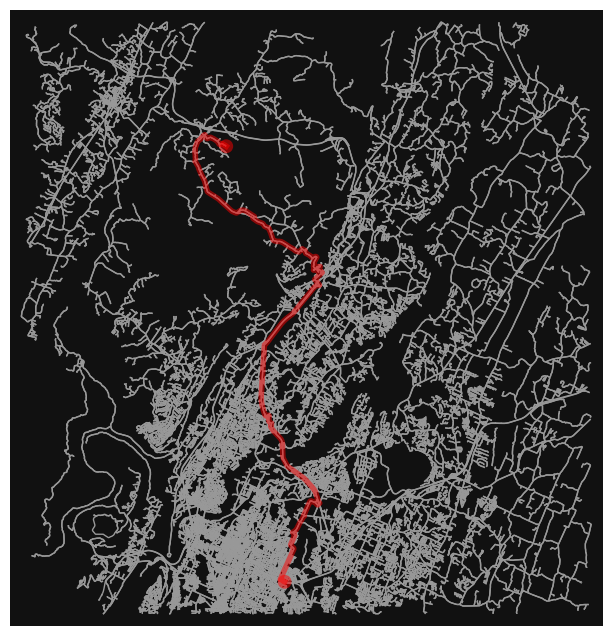

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [81]:
orig_lat, orig_lon = 35.0050, -85.2270
dest_lat, dest_lon = 35.3380, -85.2750

orig_node = ox.distance.nearest_nodes(G, X=orig_lon, Y=orig_lat)
dest_node = ox.distance.nearest_nodes(G, X=dest_lon, Y=dest_lat)

# Compute shortest path using real-time weights
route = nx.shortest_path(G, source=orig_node, target=dest_node, weight='weight')

# Visualize
ox.plot_graph_route(G, route, route_linewidth=4, node_size=0)

In [82]:
route_edges_info = []

for u, v in zip(route[:-1], route[1:]):
    data = G[u][v][0]  # Assuming key=0; use correct key if multi-graph
    length = data.get('length', None)
    weight = data.get('weight', None)
    
    route_edges_info.append({
        'from': u,
        'to': v,
        'length_m': length,
        'weight_sec': weight
    })

# Optional: Convert to DataFrame
import pandas as pd
route_edges_df = pd.DataFrame(route_edges_info)

# Display summary
print("\nTotal edges in route:", len(route_edges_df))
print("Total travel time (min):", route_edges_df['weight_sec'].sum() / 60)


Total edges in route: 147
Total travel time (min): 65.51705019508226
